>MWU는 “분포가 다른지”를 묻는 테스트고,\
>Cliff’s δ는 “얼마나 다른지”를 재는 척도고,\
>Logistic은 “위험이 몇 배로 변하는지”를 말해준다.

In [2]:
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statsmodels.api as sm

In [3]:
# loading common data
trans = pd.read_csv('./common/trans_common.csv')
users = pd.read_csv('./common/user_common.csv')
cards = pd.read_csv('./common/card_common.csv')

# loading parquet data
paths = sorted(glob("oss_batches_ratio10/oss_batch_*.parquet"))
dfs = [pd.read_parquet(p) for p in paths]
ratio10_df = pd.concat(dfs, ignore_index=True)
ratio10_df.shape

(8182479, 19)

In [4]:
ratio10_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8182479 entries, 0 to 8182478
Data columns (total 19 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   client_id                    int64  
 1   card_id                      int64  
 2   amount                       float64
 3   merchant_id                  int64  
 4   mcc                          int64  
 5   has_error                    int64  
 6   err_card_credential          int64  
 7   err_authentication           int64  
 8   err_financial                int64  
 9   err_system                   int64  
 10  is_online                    int64  
 11  is_out_of_state              int64  
 12  hour                         int16  
 13  dow                          int16  
 14  month                        int16  
 15  use_chip_Chip Transaction    int8   
 16  use_chip_Online Transaction  int8   
 17  use_chip_Swipe Transaction   int8   
 18  fraud                        int64  
dtype

In [5]:
ratio10_df.isna().sum()

client_id                      0
card_id                        0
amount                         0
merchant_id                    0
mcc                            0
has_error                      0
err_card_credential            0
err_authentication             0
err_financial                  0
err_system                     0
is_online                      0
is_out_of_state                0
hour                           0
dow                            0
month                          0
use_chip_Chip Transaction      0
use_chip_Online Transaction    0
use_chip_Swipe Transaction     0
fraud                          0
dtype: int64

In [6]:
trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7647524 entries, 0 to 7647523
Data columns (total 17 columns):
 #   Column               Dtype  
---  ------               -----  
 0   Unnamed: 0           int64  
 1   date                 object 
 2   client_id            int64  
 3   card_id              int64  
 4   amount               float64
 5   use_chip             object 
 6   merchant_id          int64  
 7   mcc                  int64  
 8   fraud                int64  
 9   has_error            int64  
 10  err_card_credential  int64  
 11  err_authentication   int64  
 12  err_financial        int64  
 13  err_system           int64  
 14  is_online            int64  
 15  home_state           object 
 16  is_out_of_state      int64  
dtypes: float64(1), int64(13), object(3)
memory usage: 991.9+ MB


In [7]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1219 entries, 0 to 1218
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         1219 non-null   int64  
 1   client_id          1219 non-null   int64  
 2   current_age        1219 non-null   int64  
 3   retirement_age     1219 non-null   int64  
 4   birth_year         1219 non-null   int64  
 5   birth_month        1219 non-null   int64  
 6   gender             1219 non-null   object 
 7   latitude           1219 non-null   float64
 8   longitude          1219 non-null   float64
 9   per_capita_income  1219 non-null   float64
 10  yearly_income      1219 non-null   float64
 11  total_debt         1219 non-null   float64
 12  credit_score       1219 non-null   int64  
 13  num_credit_cards   1219 non-null   int64  
dtypes: float64(5), int64(8), object(1)
memory usage: 133.5+ KB


In [8]:
cards.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3992 entries, 0 to 3991
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             3992 non-null   int64  
 1   card_id                3992 non-null   int64  
 2   client_id              3992 non-null   int64  
 3   card_brand             3992 non-null   object 
 4   card_type              3992 non-null   object 
 5   expires                3992 non-null   object 
 6   has_chip               3992 non-null   int64  
 7   num_cards_issued       3992 non-null   int64  
 8   credit_limit           3992 non-null   float64
 9   acct_open_date         3992 non-null   object 
 10  year_pin_last_changed  3992 non-null   int64  
dtypes: float64(1), int64(6), object(4)
memory usage: 343.2+ KB


# **Columns**

## **date**

In [9]:
trans["date"]

0          2016-11-08 19:59:00
1          2015-04-06 20:35:00
2          2017-11-09 13:02:00
3          2014-08-05 19:39:00
4          2013-08-09 19:50:00
                  ...         
7647519    2011-02-11 08:18:00
7647520    2011-04-17 07:03:00
7647521    2010-09-01 13:34:00
7647522    2013-10-30 08:41:00
7647523    2015-05-22 10:11:00
Name: date, Length: 7647524, dtype: object

In [10]:
trans["date"] = pd.to_datetime(trans["date"], errors="coerce")
trans["hour"] = trans["date"].dt.hour.astype("int16")
trans["dow"]  = trans["date"].dt.dayofweek.astype("int16")
trans["month"]= trans["date"].dt.month.astype("int16")

In [11]:
month = trans.groupby(["fraud", "month"]).size()
print(month[0])
print(month[1])

month
1     683365
2     618728
3     686964
4     663265
5     688171
6     651635
7     612671
8     614544
9     594258
10    611862
11    595105
12    615893
dtype: int64
month
1      874
2      917
3     1025
4     1031
5      929
6      717
7      919
8     1021
9      823
10     872
11     884
12    1051
dtype: int64


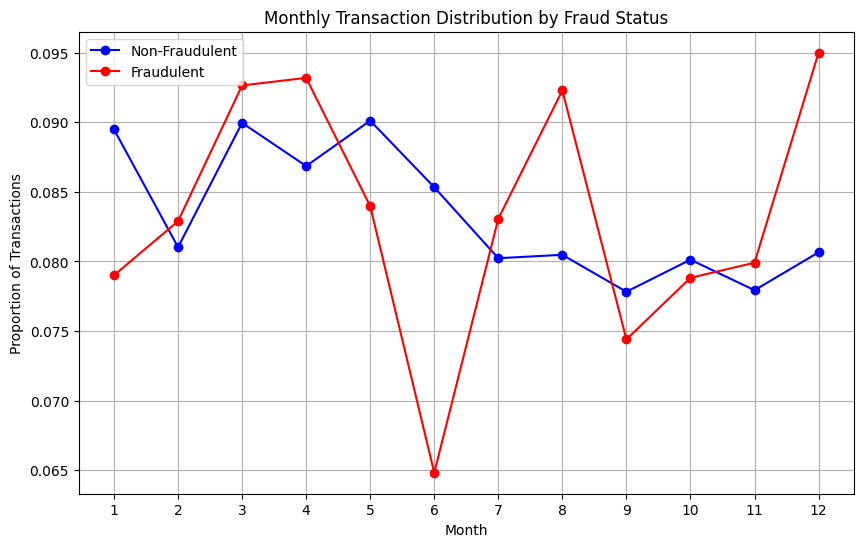

In [12]:
sum1 = month[0].sum()
sum2 = month[1].sum()
standardize1 = month[0] / sum1
standardize2 = month[1] / sum2

plt.figure(figsize=(10,6))
plt.plot(standardize1.index, standardize1.values, marker='o', label='Non-Fraudulent', color='blue')
plt.plot(standardize2.index, standardize2.values, marker='o', label='Fraudulent', color='red')
plt.title('Monthly Transaction Distribution by Fraud Status')
plt.xlabel('Month')
plt.ylabel('Proportion of Transactions')
plt.xticks(range(1, 13))
plt.legend()
plt.grid()
plt.show()

-> fraud는 특정 월에 많이 일어나는 경향\
-> non fraud는 비교적 완만

In [13]:
dfs = []
for i, p in enumerate(sorted(glob("oss_batches_ratio10/oss_batch_*.parquet"))):
    df = pd.read_parquet(p)
    df["batch_id"] = i
    dfs.append(df)

ratio10_df = pd.concat(dfs, ignore_index=True)

In [14]:
results = []

for bid, df_b in ratio10_df.groupby("batch_id"):
    tmp = df_b[["fraud", "month"]].copy()

    tmp["fraud"] = pd.to_numeric(tmp["fraud"], errors="coerce")
    tmp["month"] = pd.to_numeric(tmp["month"], errors="coerce")
    tmp = tmp.dropna(subset=["fraud", "month"])

    y = tmp["fraud"].astype(np.int8)

    X = pd.get_dummies(tmp["month"].astype(np.int16), prefix="m", drop_first=True)
    X = sm.add_constant(X)
    X = X.astype(float)

    model = sm.Logit(y, X).fit(disp=0)
    coef = model.params
    coef.name = bid
    results.append(coef)

coef_df = pd.DataFrame(results).fillna(0.0)
coef_df.head()


,const,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_10,m_11,m_12
0,-2.400907,0.158667,0.159886,0.196702,0.080505,-0.147928,0.164908,0.263899,0.090214,0.114158,0.145694,0.301915
1,-2.402979,0.138516,0.175538,0.210941,0.044810,-0.136325,0.158526,0.283931,0.082929,0.135997,0.167167,0.276947
2,-2.389434,0.136709,0.144892,0.172785,0.060399,-0.160599,0.158917,0.251040,0.068429,0.092023,0.150001,0.262155
3,-2.402876,0.162723,0.147229,0.208025,0.042875,-0.151287,0.163510,0.274691,0.075213,0.109623,0.151822,0.303417
4,-2.386282,0.137577,0.157265,0.176421,0.042264,-0.156647,0.138031,0.254838,0.036818,0.107722,0.119747,0.251435


In [15]:
coef_df

,const,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_10,m_11,m_12
0,-2.400907,0.158667,0.159886,0.196702,0.080505,-0.147928,0.164908,0.263899,0.090214,0.114158,0.145694,0.301915
1,-2.402979,0.138516,0.175538,0.210941,0.044810,-0.136325,0.158526,0.283931,0.082929,0.135997,0.167167,0.276947
2,-2.389434,0.136709,0.144892,0.172785,0.060399,-0.160599,0.158917,0.251040,0.068429,0.092023,0.150001,0.262155
3,-2.402876,0.162723,0.147229,0.208025,0.042875,-0.151287,0.163510,0.274691,0.075213,0.109623,0.151822,0.303417
4,-2.386282,0.137577,0.157265,0.176421,0.042264,-0.156647,0.138031,0.254838,0.036818,0.107722,0.119747,0.251435
...,...,...,...,...,...,...,...,...,...,...,...,...
64,-2.401840,0.153249,0.156471,0.200851,0.059062,-0.149825,0.135598,0.267031,0.075481,0.108124,0.148288,0.298890
65,-2.389959,0.171158,0.129721,0.182655,0.037917,-0.160619,0.166836,0.262590,0.054623,0.113044,0.128361,0.269048
66,-2.401529,0.151558,0.158021,0.205922,0.055654,-0.156638,0.172416,0.264984,0.092283,0.113615,0.141582,0.298115
67,-2.392995,0.138093,0.134285,0.169289,0.055088,-0.179543,0.164467,0.256449,0.060721,0.105430,0.140870,0.278035


In [16]:
coef_mean = coef_df.mean()
coef_std  = coef_df.std()

summary_df = pd.DataFrame({
    "mean": coef_mean,
    "std": coef_std
})

summary_df

,mean,std
const,-2.398721,0.009627
m_2,0.147402,0.015582
m_3,0.153555,0.013113
m_4,0.195028,0.012863
m_5,0.054036,0.012857
m_6,-0.150138,0.015743
m_7,0.160470,0.013243
m_8,0.262034,0.012426
m_9,0.079904,0.016020
m_10,0.108260,0.015874


In [17]:
summary_df = summary_df.drop(index="const")

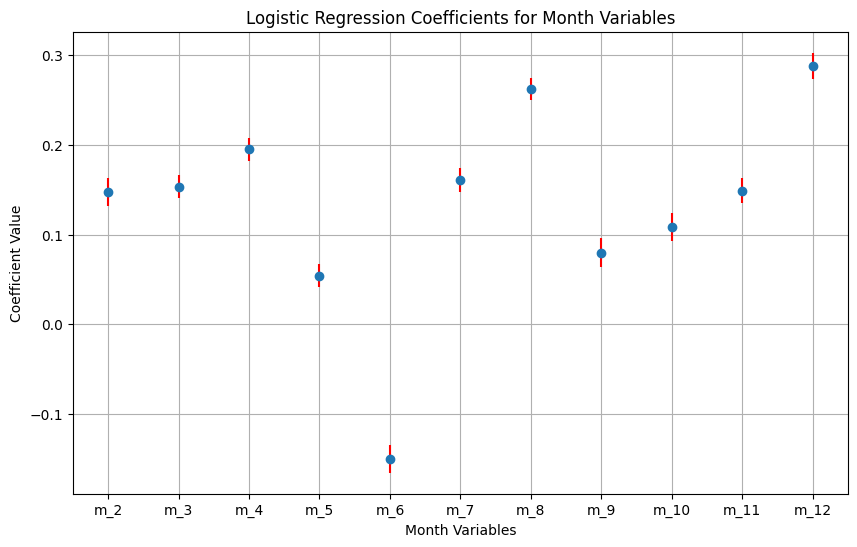

In [18]:
plt.figure(figsize=(10,6))
plt.errorbar(summary_df.index, summary_df["mean"], yerr=summary_df["std"], fmt='o', ecolor='r', capthick=2)
plt.title('Logistic Regression Coefficients for Month Variables')
plt.xlabel('Month Variables')
plt.ylabel('Coefficient Value')
plt.grid()
plt.show()

fraud는 특정 월에서 ‘조금 더 자주’ 관찰되는 경향은 반복적으로 나타나지만,\
월 변수 단독으로는 설명력이 매우 약하다.

## **amount**

In [19]:
trans["amount"].describe()

count    7.647524e+06
mean     4.298988e+01
std      8.159107e+01
min     -5.000000e+02
25%      8.930000e+00
50%      2.902000e+01
75%      6.379000e+01
max      5.696780e+03
Name: amount, dtype: float64

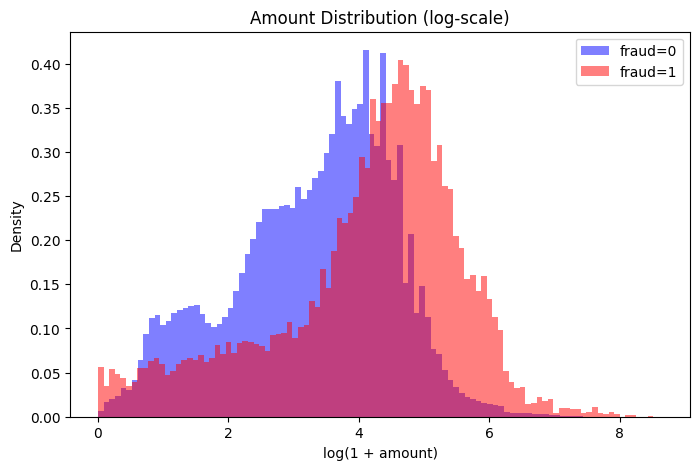

In [20]:
plt.figure(figsize=(8,5))

for label, color in [(0, "blue"), (1, "red")]:
    data = trans.loc[trans["fraud"] == label, "amount"]
    data = data[data > 0]  # 환불/취소는 일단 분리
    plt.hist(
        np.log1p(data),
        bins=100,
        density=True,
        alpha=0.5,
        label=f"fraud={label}",
        color=color
    )

plt.xlabel("log(1 + amount)")
plt.ylabel("Density")
plt.title("Amount Distribution (log-scale)")
plt.legend()
plt.show()


In [21]:
trans["amount"]

0            7.28
1            9.03
2           42.28
3            9.73
4            8.89
            ...  
7647519     13.28
7647520      6.61
7647521      3.52
7647522      5.05
7647523    127.24
Name: amount, Length: 7647524, dtype: float64

In [22]:
from scipy.stats import mannwhitneyu
import numpy as np

mw_results = []

for bid, df_b in ratio10_df.groupby("batch_id"):

    tmp = df_b[["fraud", "amount"]].copy()

    tmp = tmp[tmp["amount"] > -1]  

    a0 = np.log1p(tmp.loc[tmp["fraud"] == 0, "amount"])
    a1 = np.log1p(tmp.loc[tmp["fraud"] == 1, "amount"])

    if len(a0) < 10 or len(a1) < 10:
        mw_results.append({
            "batch": bid,
            "p_value": np.nan,
            "note": "insufficient samples"
        })
        continue

    stat, p = mannwhitneyu(a1, a0, alternative="greater")

    mw_results.append({
        "batch": bid,
        "p_value": p,
        "note": "ok"
    })

mw_df = pd.DataFrame(mw_results)
mw_df


,batch,p_value,note
0,0,0.0,ok
1,1,0.0,ok
2,2,0.0,ok
3,3,0.0,ok
4,4,0.0,ok
...,...,...,...
64,64,0.0,ok
65,65,0.0,ok
66,66,0.0,ok
67,67,0.0,ok


In [23]:
mw_df["p_value"].isna().mean()


np.float64(0.0)

In [24]:
(mw_df["p_value"] < 0.05).mean()

np.float64(1.0)

In [25]:
or_results = []

for bid, df_b in ratio10_df.groupby("batch_id"):
    tmp = df_b[df_b["amount"] > -1].copy()
    tmp["log_amount"] = np.log1p(tmp["amount"])

    y = tmp["fraud"].astype(int)
    X = sm.add_constant(tmp[["log_amount"]])

    model = sm.Logit(y, X).fit(disp=0)

    or_amt = np.exp(model.params["log_amount"])
    or_results.append(or_amt)

or_amt_df = pd.Series(or_results, name="OR_log_amount")
or_amt_df.describe()


count    69.000000
mean      1.794164
std       0.005700
min       1.779265
25%       1.790674
50%       1.794738
75%       1.798166
max       1.806168
Name: OR_log_amount, dtype: float64

>**모든 OSS 1:10 샘플에서 fraud 거래의 금액 분포는 정상 거래보다 유의하게 크다.**

## **use_chip**

In [26]:
trans["use_chip"].unique()

array(['Chip Transaction', 'Swipe Transaction', 'Online Transaction'],
      dtype=object)

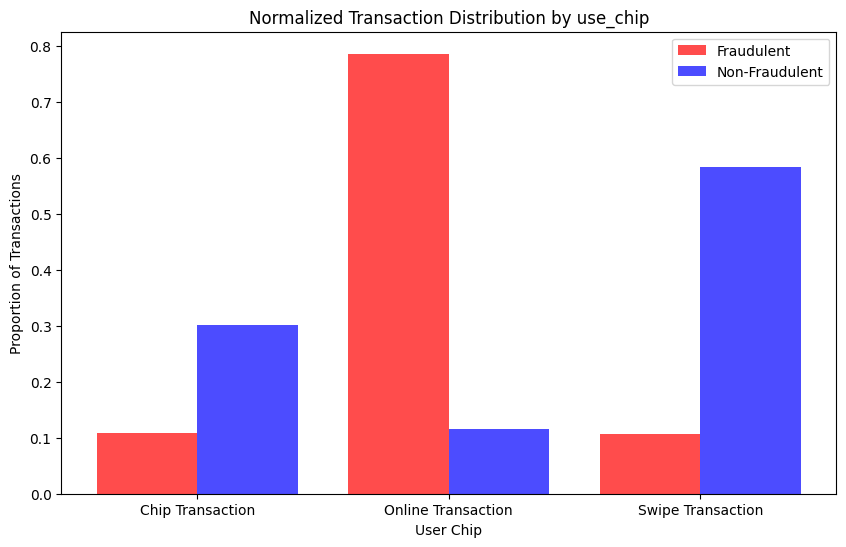

In [27]:
fraud = trans[trans["fraud"]==1]
nonfraud = trans[trans["fraud"]==0]
fraud = fraud.groupby("use_chip").count()
nonfraud = nonfraud.groupby("use_chip").count()
sumf = fraud["amount"].sum()
sumn = nonfraud["amount"].sum()
fraud["amount"] = fraud["amount"] / sumf
nonfraud["amount"] = nonfraud["amount"] / sumn

idx = sorted(set(fraud.index).union(set(nonfraud.index)))
fraud = fraud.reindex(idx, fill_value=0)
nonfraud = nonfraud.reindex(idx, fill_value=0)

x = np.arange(len(idx))   # [0, 1, 2]
w = 0.4                   # 막대 폭

plt.figure(figsize=(10,6))
plt.bar(x - w/2, fraud["amount"], width=w,
        label="Fraudulent", color="red", alpha=0.7)
plt.bar(x + w/2, nonfraud["amount"], width=w,
        label="Non-Fraudulent", color="blue", alpha=0.7)

plt.xticks(x, idx)
plt.xlabel("User Chip")
plt.ylabel("Proportion of Transactions")
plt.title("Normalized Transaction Distribution by use_chip")
plt.legend()
plt.show()

In [28]:
ratio10_df.columns

Index(['client_id', 'card_id', 'amount', 'merchant_id', 'mcc', 'has_error',
       'err_card_credential', 'err_authentication', 'err_financial',
       'err_system', 'is_online', 'is_out_of_state', 'hour', 'dow', 'month',
       'use_chip_Chip Transaction', 'use_chip_Online Transaction',
       'use_chip_Swipe Transaction', 'fraud', 'batch_id'],
      dtype='object')

In [29]:
from scipy.stats import chi2_contingency

chi_results = []

for bid, df_b in ratio10_df.groupby("batch_id"):
    ct = pd.crosstab(df_b["fraud"], df_b["use_chip_Online Transaction"])

    # 빈 테이블 방지
    if ct.shape[0] < 2 or ct.shape[1] < 2:
        continue

    chi2, p, _, _ = chi2_contingency(ct)

    chi_results.append({
        "batch": bid,
        "p_value": p
    })

chi_df = pd.DataFrame(chi_results)
chi_df

,batch,p_value
0,0,0.0
1,1,0.0
2,2,0.0
3,3,0.0
4,4,0.0
...,...,...
64,64,0.0
65,65,0.0
66,66,0.0
67,67,0.0


In [30]:
chi_df["p_value"].isna().mean()

np.float64(0.0)

In [31]:
(chi_df["p_value"] < 0.05).mean()


np.float64(1.0)

In [32]:
from scipy.stats import chi2_contingency
import numpy as np
import pandas as pd

phi_results = []

for bid, df_b in ratio10_df.groupby("batch_id"):
    ct = pd.crosstab(df_b["fraud"], df_b["use_chip_Online Transaction"])
    if ct.shape != (2, 2):
        continue

    chi2, _, _, _ = chi2_contingency(ct)
    n = ct.values.sum()
    phi = np.sqrt(chi2 / n)

    phi_results.append({
        "batch": bid,
        "phi": phi
    })

phi_df = pd.DataFrame(phi_results)
phi_df.describe()


,batch,phi
count,69.000000,69.000000
mean,34.000000,0.512118
std,20.062403,0.003645
min,0.000000,0.507323
25%,17.000000,0.510093
50%,34.000000,0.511466
75%,51.000000,0.513418
max,68.000000,0.526793


In [33]:
import statsmodels.api as sm
import numpy as np
import pandas as pd

or_results = []

for bid, df_b in ratio10_df.groupby("batch_id"):
    X = sm.add_constant(df_b[["use_chip_Online Transaction"]])
    y = df_b["fraud"]

    model = sm.Logit(y, X).fit(disp=0)

    or_online = np.exp(model.params["use_chip_Online Transaction"])

    or_results.append({
        "batch": bid,
        "OR_online": or_online
    })

or_df = pd.DataFrame(or_results)
or_df.describe()


,batch,OR_online
count,69.000000,69.000000
mean,34.000000,28.499321
std,20.062403,0.559811
min,0.000000,27.712189
25%,17.000000,28.199258
50%,34.000000,28.396694
75%,51.000000,28.619500
max,68.000000,30.756898


> Online transaction usage shows a strong and highly stable association with fraud occurrence across all balanced OSS samples (φ ≈ 0.51).

## **has error**

In [34]:
trans.head()

,Unnamed: 0,date,client_id,card_id,amount,use_chip,merchant_id,mcc,fraud,has_error,err_card_credential,err_authentication,err_financial,err_system,is_online,home_state,is_out_of_state,hour,dow,month
0,0,2016-11-08 19:59:00,0,1271,7.28,Chip Transaction,13153,5812,0,0,0,0,0,0,0,ME,0,19,1,11
1,1,2015-04-06 20:35:00,0,4639,9.03,Chip Transaction,44919,5814,0,0,0,0,0,0,0,ME,1,20,0,4
2,2,2017-11-09 13:02:00,0,1271,42.28,Chip Transaction,60569,5300,0,0,0,0,0,0,0,ME,0,13,3,11
3,3,2014-08-05 19:39:00,0,1271,9.73,Swipe Transaction,887,5812,0,0,0,0,0,0,0,ME,1,19,1,8
4,4,2013-08-09 19:50:00,0,1271,8.89,Swipe Transaction,98648,5814,0,0,0,0,0,0,0,ME,0,19,4,8


## **err_card_credential**

## **err_authentication**

## **err_financial**

## **error_system**

In [35]:
err_cols = [
    "err_card_credential",
    "err_authentication",
    "err_financial",
    "err_system"
]
err_counts = (
    trans
    .groupby("fraud")[err_cols]
    .sum()
    .T 
)

err_counts.columns = ["Non-Fraud", "Fraud"]
err_counts


,Non-Fraud,Fraud
err_card_credential,11399,255
err_authentication,19281,57
err_financial,75502,148
err_system,15367,27


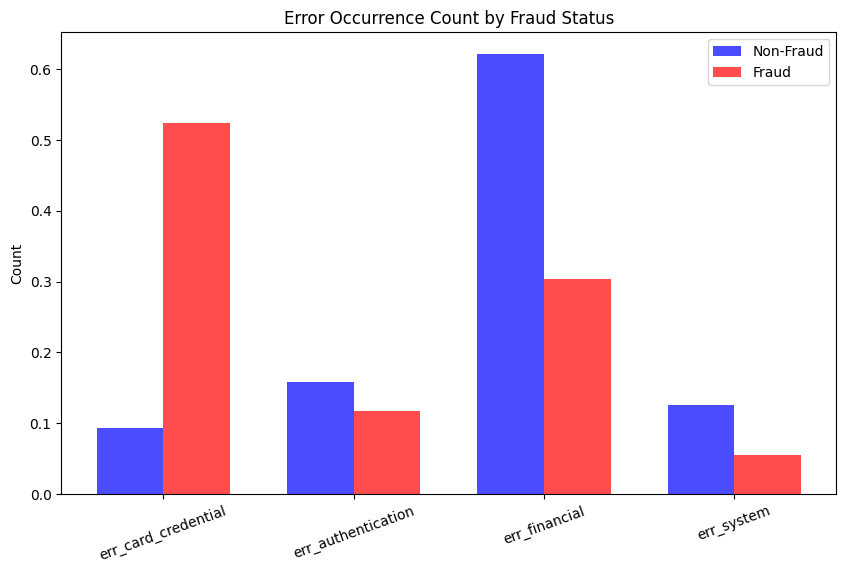

In [36]:
x = np.arange(len(err_cols))
w = 0.35

plt.figure(figsize=(10,6))
plt.bar(x - w/2, err_counts["Non-Fraud"]/err_counts["Non-Fraud"].sum(), width=w, label="Non-Fraud", color="blue", alpha=0.7)
plt.bar(x + w/2, err_counts["Fraud"]/err_counts["Fraud"].sum(), width=w, label="Fraud", color="red", alpha=0.7)

plt.xticks(x, err_cols, rotation=20)
plt.ylabel("Count")
plt.title("Error Occurrence Count by Fraud Status")
plt.legend()
plt.show()


In [37]:
tmp = trans[["fraud", "err_card_credential"]].copy()

y = tmp["fraud"].astype(int)
X = sm.add_constant(tmp[["err_card_credential"]])

model = sm.Logit(y, X).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.010844
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:                  fraud   No. Observations:              7647524
Model:                          Logit   Df Residuals:                  7647522
Method:                           MLE   Df Model:                            1
Date:                Sat, 31 Jan 2026   Pseudo R-squ.:                0.005511
Time:                        20:53:33   Log-Likelihood:                -82931.
converged:                       True   LL-Null:                       -83391.
Covariance Type:            nonrobust   LLR p-value:                6.703e-202
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -6.5589      0.010   -681.391      0.000      -6.578      -6.540
e

In [38]:
or_results = []

for bid, df_b in ratio10_df.groupby("batch_id"):
    tmp = df_b[["fraud", "err_card_credential"]].copy()

    # err가 전혀 없는 배치는 스킵
    if tmp["err_card_credential"].sum() == 0:
        continue

    y = tmp["fraud"].astype(int)
    X = sm.add_constant(tmp[["err_card_credential"]])

    model = sm.Logit(y, X).fit(disp=0)

    coef = model.params["err_card_credential"]
    OR = np.exp(coef)
    pval = model.pvalues["err_card_credential"]

    or_results.append({
        "batch": bid,
        "OR_err_card_credential": OR,
        "p_value": pval
    })

or_df = pd.DataFrame(or_results)
or_df.describe()


,batch,OR_err_card_credential,p_value
count,69.000000,69.000000,6.900000e+01
mean,34.000000,16.084004,5.219833e-160
std,20.062403,1.271275,4.261328e-159
min,0.000000,12.886316,1.730793e-165
25%,17.000000,15.424770,2.354059e-164
50%,34.000000,15.991736,1.047224e-163
75%,51.000000,16.815855,7.295143e-163
max,68.000000,19.976505,3.540470e-158


> Credential-related errors constitute a critical early warning signal and should be treated as a high-priority risk indicator.

## **home_state**

In [39]:
state_counts = (
    trans
    .groupby(["fraud", "home_state"])
    .size()
    .unstack(fill_value=0)
)

state_counts.head()

home_state,AL,AR,AZ,CA,CO,CT,DC,DE,FL,GA,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
fraud,,,,,,,,,,,,,,,,,,,,,
0,122620,61218,122024,922770,98561,88874,4408,24830,443237,232362,...,20915,179577,621777,19413,149724,10659,177525,111357,35315,4961
1,237,54,184,1302,126,147,6,18,623,322,...,63,218,1005,37,245,28,210,248,72,5


In [40]:
state_norm = (
    trans
    .groupby("fraud")["home_state"]
    .value_counts(normalize=True)
    .unstack(fill_value=0)
)

state_order = (
    trans["home_state"]
    .value_counts()
    .index
)

state_norm = state_norm.reindex(columns=state_order)

state_norm.head()

home_state,CA,TX,NY,FL,OH,IL,NC,PA,MI,GA,...,NE,ME,DE,SD,UT,MT,ND,VT,WY,DC
fraud,,,,,,,,,,,,,,,,,,,,,
0,0.125350,0.084463,0.074661,0.060210,0.044117,0.040800,0.038233,0.033780,0.032723,0.031564,...,0.004539,0.003615,0.003373,0.002841,0.002637,0.002199,0.001975,0.001448,0.000674,0.000599
1,0.121184,0.093541,0.062826,0.057986,0.038533,0.036299,0.044676,0.028295,0.038068,0.029970,...,0.003723,0.001862,0.001675,0.005864,0.003444,0.003630,0.003071,0.002606,0.000465,0.000558


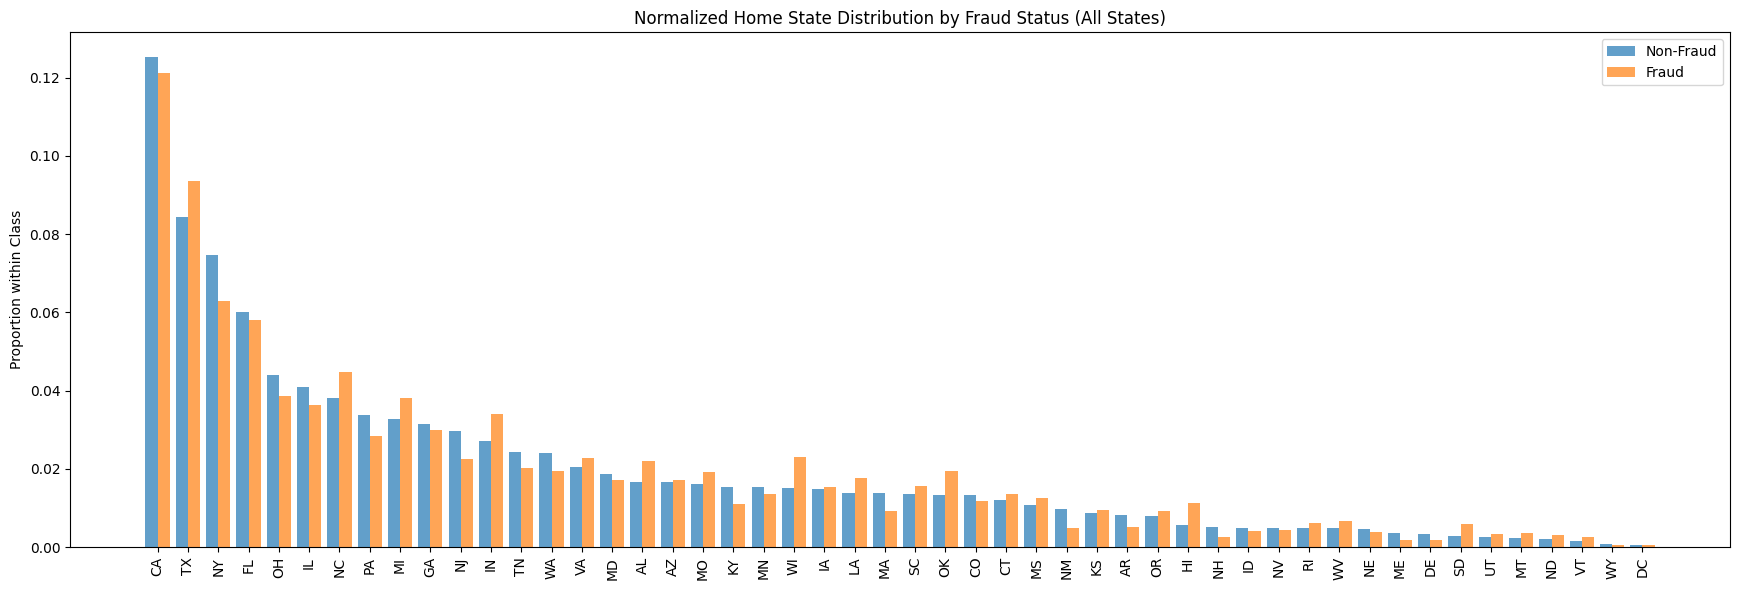

In [41]:
x = np.arange(len(state_norm.columns))
w = 0.4

plt.figure(figsize=(max(16, len(state_norm.columns)*0.35), 6))
plt.bar(x - w/2, state_norm.loc[0].values, width=w, label="Non-Fraud", alpha=0.7)
plt.bar(x + w/2, state_norm.loc[1].values, width=w, label="Fraud", alpha=0.7)

plt.xticks(x, state_norm.columns, rotation=90)
plt.ylabel("Proportion within Class")
plt.title("Normalized Home State Distribution by Fraud Status (All States)")
plt.legend()
plt.tight_layout()
plt.show()

## **is_out_of_state**

In [42]:
out_norm = (
    trans
    .groupby("fraud")["is_out_of_state"]
    .value_counts(normalize=True)
    .unstack(fill_value=0)
)

out_norm

is_out_of_state,0,1
fraud,,
0,0.802223,0.197777
1,0.103950,0.896050


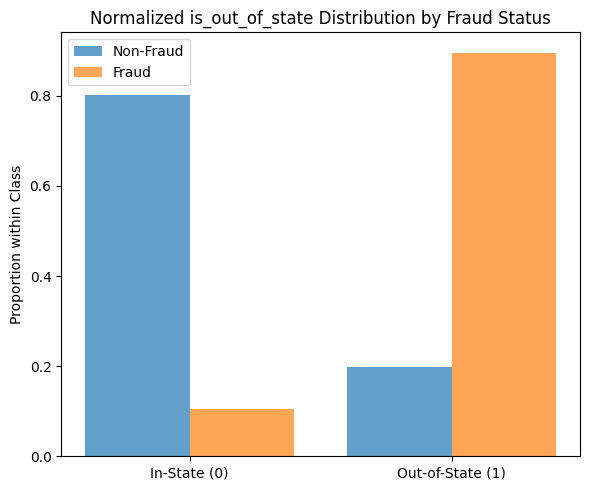

In [43]:
labels = ["In-State (0)", "Out-of-State (1)"]
x = np.arange(len(labels))
w = 0.4

plt.figure(figsize=(6,5))
plt.bar(x - w/2, out_norm.loc[0], width=w, label="Non-Fraud", alpha=0.7)
plt.bar(x + w/2, out_norm.loc[1], width=w, label="Fraud", alpha=0.7)

plt.xticks(x, labels)
plt.ylabel("Proportion within Class")
plt.title("Normalized is_out_of_state Distribution by Fraud Status")
plt.legend()
plt.tight_layout()
plt.show()


In [44]:
from scipy.stats import chi2_contingency

ct = pd.crosstab(trans["fraud"], trans["is_out_of_state"])
chi2, p, _, _ = chi2_contingency(ct)

print("Chi-square p-value:", p)


Chi-square p-value: 0.0


In [45]:
df = trans[["fraud", "is_out_of_state"]].dropna()

X = sm.add_constant(df["is_out_of_state"])
y = df["fraud"]

model = sm.Logit(y, X).fit(disp=0)
print(model.summary())

print("OR:", np.exp(model.params["is_out_of_state"]))


                           Logit Regression Results                           
Dep. Variable:                  fraud   No. Observations:              7647524
Model:                          Logit   Df Residuals:                  7647522
Method:                           MLE   Df Model:                            1
Date:                Sat, 31 Jan 2026   Pseudo R-squ.:                  0.1511
Time:                        20:53:58   Log-Likelihood:                -70788.
converged:                       True   LL-Null:                       -83391.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -8.5806      0.029   -290.954      0.000      -8.638      -8.523
is_out_of_state     3.5543      0.031    114.048      0.000       3.493       3.615
OR: 34.964393366160074


In [46]:

or_results = []

for bid, df_b in ratio10_df.groupby("batch_id"):

    tmp = df_b[["fraud", "is_out_of_state"]].dropna()

    if tmp["fraud"].nunique() < 2:
        continue

    X = sm.add_constant(tmp["is_out_of_state"])
    y = tmp["fraud"]

    model = sm.Logit(y, X).fit(disp=0)

    or_results.append({
        "batch": bid,
        "OR_is_out_of_state": np.exp(model.params["is_out_of_state"]),
        "coef": model.params["is_out_of_state"],
        "p_value": model.pvalues["is_out_of_state"]
    })

or_df = pd.DataFrame(or_results)
or_df.head()


,batch,OR_is_out_of_state,coef,p_value
0,0,35.826408,3.578685,0.0
1,1,35.579925,3.571782,0.0
2,2,36.169003,3.588202,0.0
3,3,35.866309,3.579798,0.0
4,4,35.571954,3.571558,0.0


In [47]:
or_df["OR_is_out_of_state"].describe()


count    69.000000
mean     35.908631
std       0.394082
min      35.187466
25%      35.614631
50%      35.879528
75%      36.108993
max      37.252762
Name: OR_is_out_of_state, dtype: float64

> Out-of-state behavior alone explains a substantial portion of fraud risk, supporting its use as a primary early-warning signal.

## **has_error**

In [48]:
error_norm = (
    trans
    .groupby("fraud")["has_error"]
    .value_counts(normalize=True)
    .unstack(fill_value=0)
)

error_norm

has_error,0,1
fraud,,
0,0.984145,0.015855
1,0.956431,0.043569


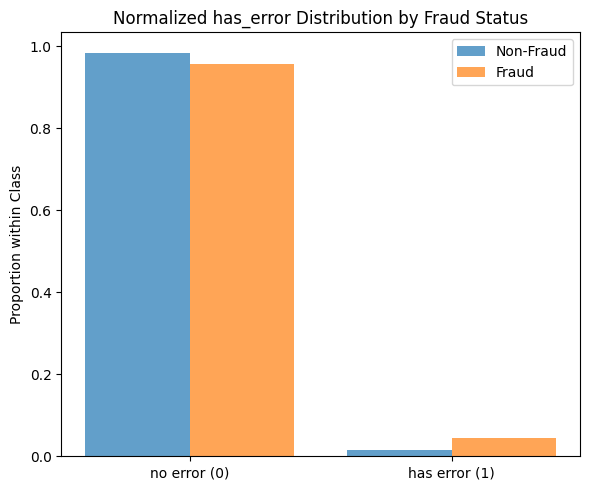

In [49]:
labels = ["no error (0)", "has error (1)"]
x = np.arange(len(labels))
w = 0.4

plt.figure(figsize=(6,5))
plt.bar(x - w/2, error_norm.loc[0], width=w, label="Non-Fraud", alpha=0.7)
plt.bar(x + w/2, error_norm.loc[1], width=w, label="Fraud", alpha=0.7)

plt.xticks(x, labels)
plt.ylabel("Proportion within Class")
plt.title("Normalized has_error Distribution by Fraud Status")
plt.legend()
plt.tight_layout()
plt.show()


## **mcc**

In [50]:
mcc_norm = (
    trans
    .groupby("fraud")["mcc"]
    .value_counts(normalize=True)
    .unstack(fill_value=0)
)

state_order = (
    trans["mcc"]
    .value_counts()
    .index
)

mcc_norm = mcc_norm.reindex(columns=state_order)

mcc_norm.head()

mcc,5411,5499,5541,5812,5912,4784,5300,4829,5814,4121,...,4411,3008,3009,3005,3007,3006,3075,5722,3144,5733
fraud,,,,,,,,,,,,,,,,,,,,,
0,0.119809,0.110115,0.107548,0.075254,0.058133,0.050309,0.045233,0.044330,0.037502,0.037329,...,0.000012,0.000029,0.000028,0.000027,0.000027,0.000025,0.000026,0.000025,0.000022,0.000015
1,0.019705,0.003706,0.003977,0.006418,0.034258,0.000000,0.088945,0.065082,0.018530,0.020067,...,0.014553,0.001265,0.001537,0.001627,0.001265,0.002169,0.000904,0.000633,0.001627,0.005966


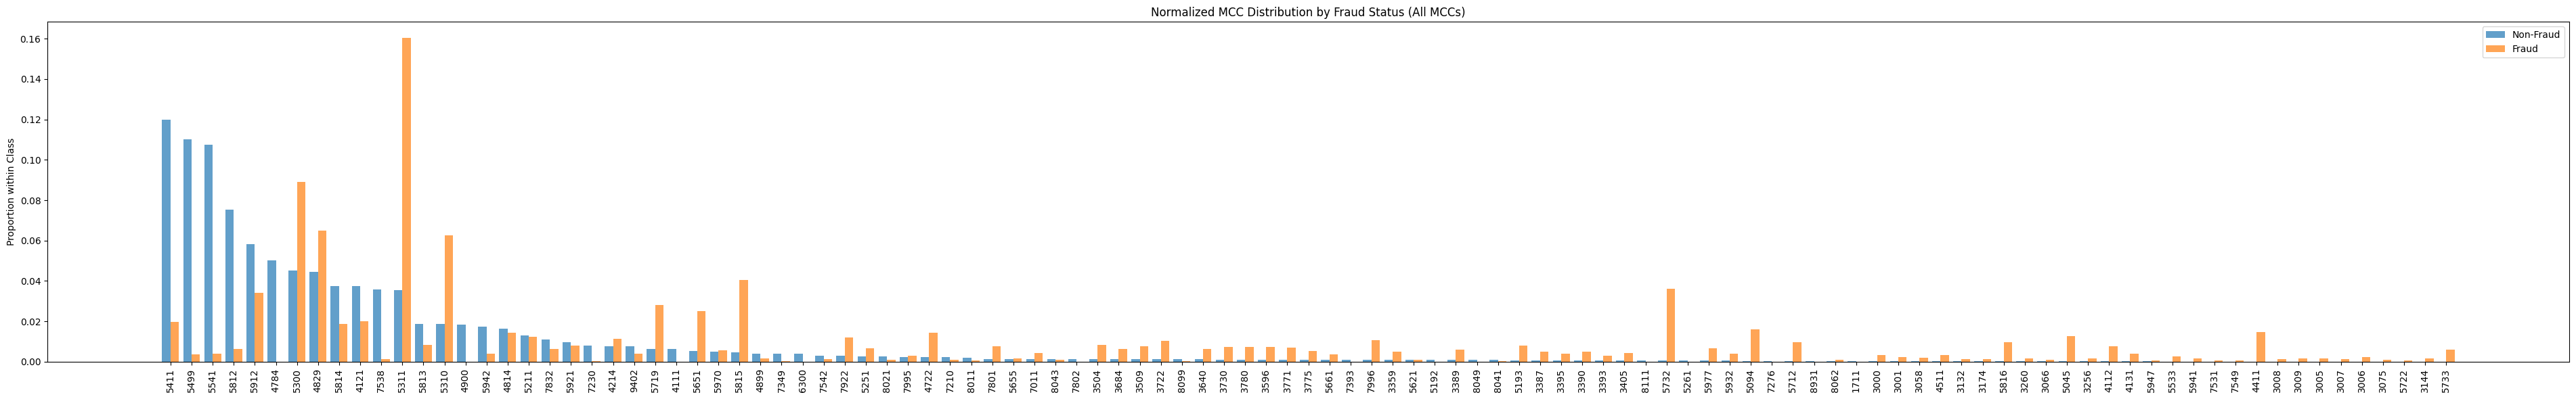

In [51]:
x = np.arange(len(mcc_norm.columns))
w = 0.4

plt.figure(figsize=(max(16, len(mcc_norm.columns)*0.35), 6))
plt.bar(x - w/2, mcc_norm.loc[0].values, width=w, label="Non-Fraud", alpha=0.7)
plt.bar(x + w/2, mcc_norm.loc[1].values, width=w, label="Fraud", alpha=0.7)

plt.xticks(x, mcc_norm.columns, rotation=90)
plt.ylabel("Proportion within Class")
plt.title("Normalized MCC Distribution by Fraud Status (All MCCs)")
plt.legend()
plt.tight_layout()
plt.show()

In [52]:
mcc_norm["diff"] = mcc_norm.loc[1] - mcc_norm.loc[0]
mcc_norm["ratio"] = mcc_norm.loc[1] / (mcc_norm.loc[0] + 1e-9)

mcc_norm.sort_values("diff", ascending=False).head(10)


mcc,5411,5499,5541,5812,5912,4784,5300,4829,5814,4121,...,3009,3005,3007,3006,3075,5722,3144,5733,diff,ratio
fraud,,,,,,,,,,,,,,,,,,,,,
0,0.119809,0.110115,0.107548,0.075254,0.058133,0.050309,0.045233,0.044330,0.037502,0.037329,...,0.000028,0.000027,0.000027,0.000025,0.000026,0.000025,0.000022,0.000015,NaN,NaN
1,0.019705,0.003706,0.003977,0.006418,0.034258,0.000000,0.088945,0.065082,0.018530,0.020067,...,0.001537,0.001627,0.001265,0.002169,0.000904,0.000633,0.001627,0.005966,NaN,NaN


In [53]:
mcc_count = trans["mcc"].value_counts()
valid_mcc = mcc_count[mcc_count >= 1000].index

mcc_candidate = mcc_norm.loc[:, valid_mcc].copy()

In [54]:
mcc_candidate = mcc_candidate.T   # 행=mcc, 열=fraud

mcc_candidate["diff"] = mcc_candidate[1] - mcc_candidate[0]
mcc_candidate["ratio"] = mcc_candidate[1] / (mcc_candidate[0] + 1e-9)

mcc_candidate.sort_values("diff", ascending=False).head(15)

fraud,0,1,diff,ratio
mcc,,,,
5311,0.035576,0.160354,0.124779,4.507419
5310,0.018529,0.062551,0.044022,3.375834
5300,0.045233,0.088945,0.043712,1.966383
5815,0.004669,0.040405,0.035736,8.653302
5732,0.000480,0.036157,0.035676,75.315758
5719,0.006425,0.028202,0.021777,4.389636
4829,0.044330,0.065082,0.020752,1.468118
5651,0.005419,0.025038,0.019619,4.620484
5094,0.000370,0.015999,0.015629,43.263996


In [55]:
TOP_K = 15

top_mccs = (
    mcc_candidate
    .sort_values("diff", ascending=False)
    .head(TOP_K)
    .index
)

top_mccs


Index([5311, 5310, 5300, 5815, 5732, 5719, 4829, 5651, 5094, 5045, 4722, 7996,
       5816, 5712, 3722],
      dtype='object', name='mcc')

In [56]:
logit_results = []

for mcc in top_mccs:
    tmp = trans[["fraud"]].copy()
    tmp["is_mcc"] = (trans["mcc"] == mcc).astype(int)

    # 안정성 체크 (거의 항상 통과하겠지만 습관적으로)
    if tmp["is_mcc"].sum() < 50:
        continue

    X = sm.add_constant(tmp["is_mcc"])
    y = tmp["fraud"]

    model = sm.Logit(y, X).fit(disp=0)

    logit_results.append({
        "mcc": mcc,
        "OR": np.exp(model.params["is_mcc"]),
        "coef": model.params["is_mcc"],
        "p_value": model.pvalues["is_mcc"],
        "count": tmp["is_mcc"].sum()
    })

mcc_logit_df = pd.DataFrame(logit_results).sort_values("OR", ascending=False)
mcc_logit_df


,mcc,OR,coef,p_value,count
4,5732,78.103720,4.358038,0.000000e+00,4066
9,5045,67.628135,4.214024,0.000000e+00,1587
12,5816,49.715467,3.906316,0.000000e+00,1622
8,5094,43.951302,3.783082,0.000000e+00,3001
13,5712,36.531272,3.598169,1.394470e-285,2148
11,7996,12.581688,2.532242,2.691934e-163,6713
14,3722,9.010518,2.198393,4.089463e-120,9007
3,5815,8.975556,2.194505,0.000000e+00,36104
10,4722,6.146411,1.815868,4.091933e-114,18349
0,5311,5.177261,1.644276,0.000000e+00,273446


In [57]:
batch_results = []

for bid, df_b in ratio10_df.groupby("batch_id"):
    for mcc in top_mccs:
        tmp = df_b[["fraud"]].copy()
        tmp["is_mcc"] = (df_b["mcc"] == mcc).astype(int)

        if tmp["is_mcc"].sum() < 10:
            continue

        X = sm.add_constant(tmp["is_mcc"])
        y = tmp["fraud"]

        model = sm.Logit(y, X).fit(disp=0)

        batch_results.append({
            "batch": bid,
            "mcc": mcc,
            "OR": np.exp(model.params["is_mcc"]),
            "p_value": model.pvalues["is_mcc"]
        })

batch_mcc_df = pd.DataFrame(batch_results)


In [58]:
batch_mcc_df.groupby("mcc")["OR"].describe()

,count,mean,std,min,25%,50%,75%,max
mcc,,,,,,,,
3722,69.0,11.039860,1.285038,8.592517,10.163241,11.137262,11.900929,14.847966
4722,69.0,7.258191,0.537818,5.971887,6.906687,7.249651,7.582881,8.647282
4829,69.0,1.512791,0.024531,1.453915,1.497525,1.512229,1.527117,1.602958
5045,69.0,104.953972,33.630791,53.080092,81.279330,98.602948,115.004730,230.075681
5094,69.0,59.075359,13.550128,34.349769,49.958681,56.428040,62.576104,124.695782
5300,69.0,2.118630,0.029812,2.060239,2.097682,2.117856,2.132414,2.203715
5310,69.0,3.714924,0.099761,3.493153,3.636780,3.736256,3.785722,3.944807
5311,69.0,5.661018,0.112820,5.473070,5.564049,5.660537,5.743282,6.009175
5651,69.0,5.161591,0.210578,4.706739,4.994923,5.173673,5.290080,5.759237


---

In [59]:
users["retirement_age"].unique()

array([69, 74, 64, 65, 72, 67, 61, 57, 68, 66, 63, 71, 55, 60, 62, 70, 73,
       54, 59, 58, 75, 77, 53, 56, 78, 76, 79])

In [60]:
users["current_age"].unique()

array([ 33,  43,  48,  49,  54,  65,  39,  52,  79,  75,  76,  82,  86,
        56,  78,  77,  41,  45,  71,  85,  61,  62,  47,  69,  68,  29,
        28,  38,  44,  40,  51,  42,  80,  99,  37,  70,  66,  24,  58,
        35,  63,  59,  50,  74,  31,  34,  64,  30,  36,  32,  67,  57,
        73,  60,  55,  46,  94,  90,  91,  81,  53,  27,  84,  72,  83,
        87,  26,  88,  25,  89,  92, 101,  98,  23])

---

# **Hypothesis**

## **공격자 관점 가설**

### **타인의 신용 (Target Selection 가설)**

**H1-1. 고신용 타깃 가설**
>credit_score ↑\
>total_debt ↓\
>→ 승인율 높고 차단까지 시간 길다

In [63]:
users.columns

Index(['Unnamed: 0', 'client_id', 'current_age', 'retirement_age',
       'birth_year', 'birth_month', 'gender', 'latitude', 'longitude',
       'per_capita_income', 'yearly_income', 'total_debt', 'credit_score',
       'num_credit_cards'],
      dtype='object')

In [64]:
users["credit_score"].unique()

array([763, 704, 673, 681, 716, 711, 714, 588, 652, 759, 630, 757, 850,
       747, 708, 613, 789, 695, 596, 737, 683, 621, 583, 726, 684, 680,
       654, 632, 712, 733, 702, 688, 730, 701, 717, 823, 706, 655, 801,
       660, 645, 748, 674, 783, 564, 709, 625, 498, 723, 738, 799, 802,
       705, 644, 689, 593, 685, 590, 813, 713, 624, 734, 686, 788, 725,
       753, 781, 721, 786, 824, 724, 729, 722, 696, 698, 643, 691, 641,
       739, 638, 675, 835, 800, 663, 594, 782, 773, 666, 785, 796, 731,
       771, 658, 694, 768, 668, 667, 728, 727, 840, 797, 779, 746, 720,
       732, 776, 809, 745, 804, 755, 629, 687, 744, 810, 798, 736, 693,
       769, 540, 563, 791, 761, 618, 699, 765, 665, 710, 793, 661, 622,
       750, 679, 690, 752, 692, 719, 715, 628, 829, 772, 700, 703, 697,
       764, 807, 735, 792, 775, 812, 760, 740, 770, 806, 741, 610, 790,
       718, 633, 635, 751, 530, 608, 784, 767, 682, 672, 803, 651, 676,
       811, 766, 627, 814, 749, 778, 602, 669, 834, 662, 589, 63

In [65]:
trans

,Unnamed: 0,date,client_id,card_id,amount,use_chip,merchant_id,mcc,fraud,has_error,err_card_credential,err_authentication,err_financial,err_system,is_online,home_state,is_out_of_state,hour,dow,month
0,0,2016-11-08 19:59:00,0,1271,7.28,Chip Transaction,13153,5812,0,0,0,0,0,0,0,ME,0,19,1,11
1,1,2015-04-06 20:35:00,0,4639,9.03,Chip Transaction,44919,5814,0,0,0,0,0,0,0,ME,1,20,0,4
2,2,2017-11-09 13:02:00,0,1271,42.28,Chip Transaction,60569,5300,0,0,0,0,0,0,0,ME,0,13,3,11
3,3,2014-08-05 19:39:00,0,1271,9.73,Swipe Transaction,887,5812,0,0,0,0,0,0,0,ME,1,19,1,8
4,4,2013-08-09 19:50:00,0,1271,8.89,Swipe Transaction,98648,5814,0,0,0,0,0,0,0,ME,0,19,4,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7647519,7647519,2011-02-11 08:18:00,1998,2160,13.28,Swipe Transaction,59935,5499,0,0,0,0,0,0,0,CA,0,8,4,2
7647520,7647520,2011-04-17 07:03:00,1998,2160,6.61,Online Transaction,9932,5311,0,0,0,0,0,0,0,CA,1,7,6,4
7647521,7647521,2010-09-01 13:34:00,1998,2160,3.52,Swipe Transaction,59935,5499,0,0,0,0,0,0,0,CA,0,13,2,9
7647522,7647522,2013-10-30 08:41:00,1998,2160,5.05,Online Transaction,47399,5815,0,0,0,0,0,0,0,CA,1,8,2,10


In [67]:
# fraud = 1인 사람 중 credit_score 분포 확인
fraud_users = trans[trans["fraud"]==1]
fraud_user_id = fraud_users["client_id"].unique()
credit_scores = users[users["client_id"].isin(fraud_user_id)]["credit_score"]
count_score = credit_scores.value_counts().sort_index()
count_score

credit_score
488     1
489     1
491     1
498     2
500     1
       ..
842     1
846     1
847     1
849     2
850    17
Name: count, Length: 274, dtype: int64

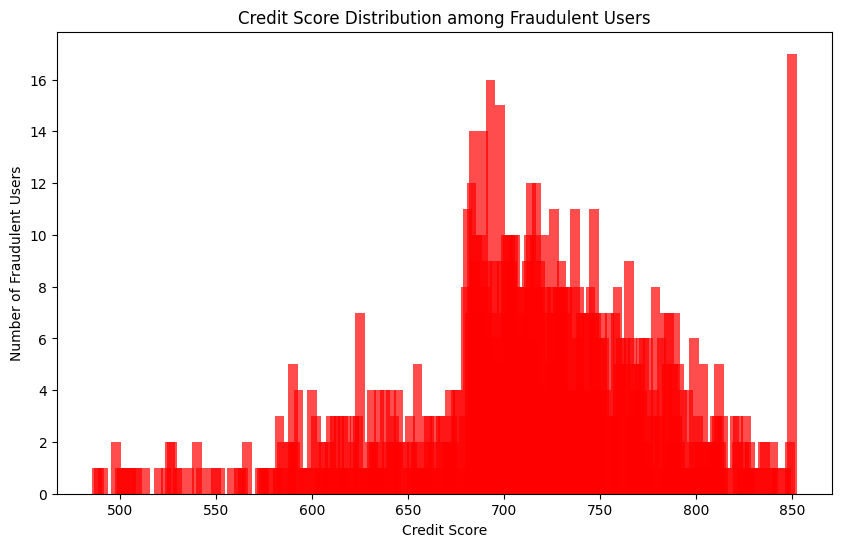

In [68]:
plt.figure(figsize=(10,6))
plt.bar(count_score.index, count_score.values, width=5, color='red', alpha=0.7)
plt.xlabel('Credit Score')
plt.ylabel('Number of Fraudulent Users')
plt.title('Credit Score Distribution among Fraudulent Users')
plt.show()

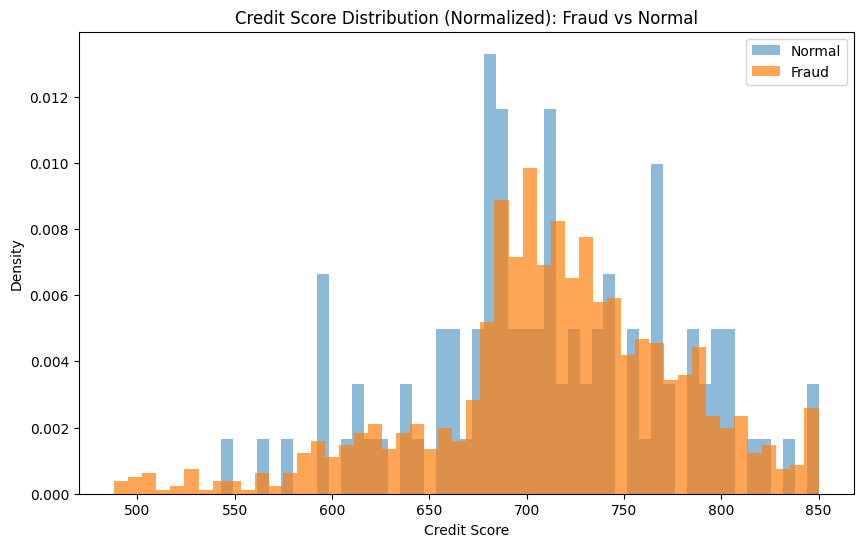

In [91]:
fraud = users[users["client_id"].isin(fraud_user_id)]["credit_score"]
normal = users[~users["client_id"].isin(fraud_user_id)]["credit_score"]

plt.figure(figsize=(10,6))
plt.hist(normal, bins=50, density=True, alpha=0.5, label="Normal")
plt.hist(fraud, bins=50, density=True, alpha=0.7, label="Fraud")

plt.xlabel("Credit Score")
plt.ylabel("Density")
plt.title("Credit Score Distribution (Normalized): Fraud vs Normal")
plt.legend()
plt.show()



In [69]:
# dept
dept_count = users[users["client_id"].isin(fraud_user_id)]["total_debt"]
count_dept = dept_count.value_counts().sort_index()
count_dept

total_debt
0.0         61
5.0          1
66.0         1
69.0         1
93.0         1
            ..
255288.0     1
317964.0     1
328089.0     1
448929.0     1
461854.0     1
Name: count, Length: 1057, dtype: int64

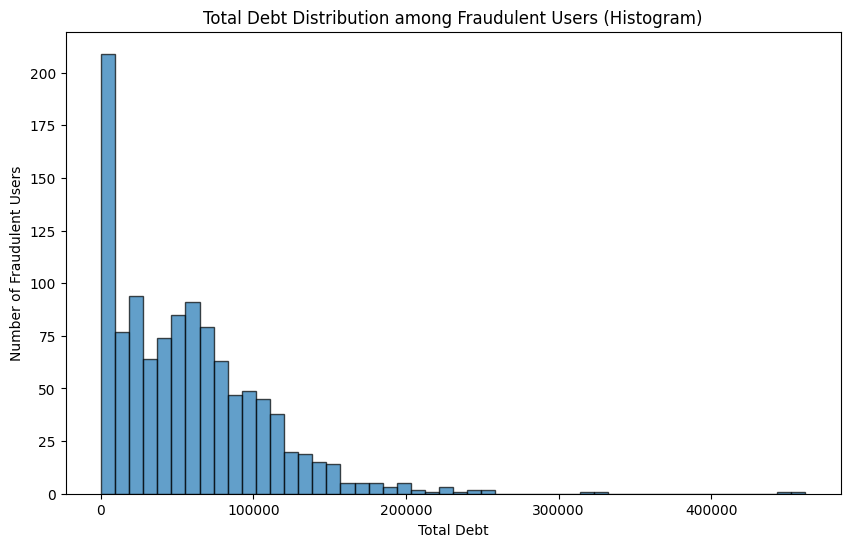

In [73]:
dept = users.loc[users["client_id"].isin(fraud_user_id), "total_debt"].dropna()

plt.figure(figsize=(10,6))
plt.hist(dept, bins=50, edgecolor="black", alpha=0.7)
plt.xlabel("Total Debt")
plt.ylabel("Number of Fraudulent Users")
plt.title("Total Debt Distribution among Fraudulent Users (Histogram)")
plt.show()


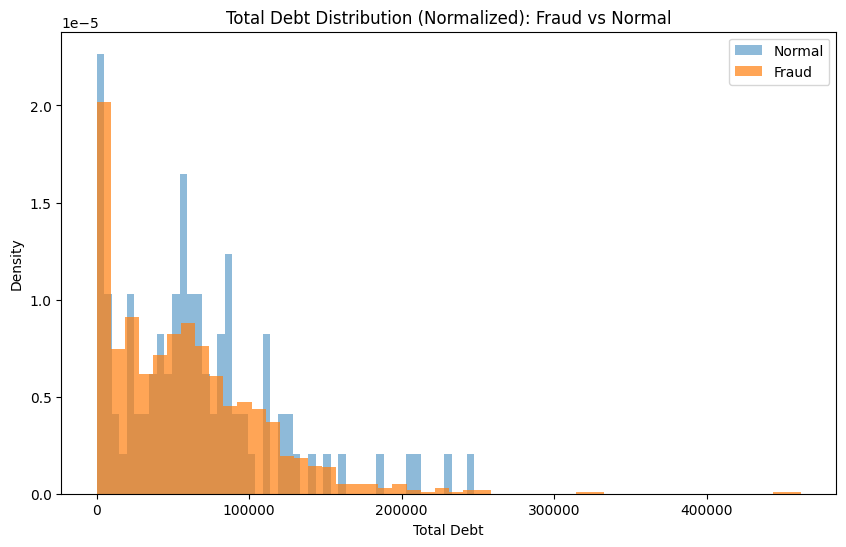

In [93]:
fraud_debt = users.loc[
    users["client_id"].isin(fraud_user_id),
    "total_debt"
].dropna()

normal_debt = users.loc[
    ~users["client_id"].isin(fraud_user_id),
    "total_debt"
].dropna()

plt.figure(figsize=(10,6))
plt.hist(normal_debt, bins=50, density=True, alpha=0.5, label="Normal")
plt.hist(fraud_debt, bins=50, density=True, alpha=0.7, label="Fraud")

plt.xlabel("Total Debt")
plt.ylabel("Density")
plt.title("Total Debt Distribution (Normalized): Fraud vs Normal")
plt.legend()
plt.show()


**H1-2. 소득 대비 부채 여유 가설**

yearly_income 대비 total_debt 낮은 고객\
→ “정상 소비 여력”으로 위장 가능

In [74]:
income = users[users["client_id"].isin(fraud_user_id)]["yearly_income"]
dept = users.loc[users["client_id"].isin(fraud_user_id), "total_debt"].dropna()
ratio = dept / income
ratio

0       0.607233
1       0.321583
2       2.945677
3       0.668969
4       1.509361
          ...   
1214    1.314390
1215    0.235143
1216    1.337160
1217    0.666675
1218    1.224806
Length: 1121, dtype: float64

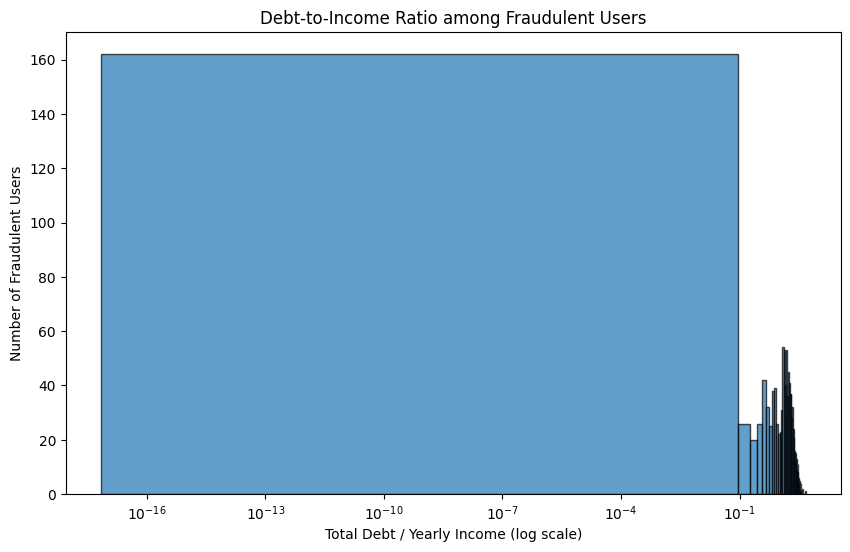

In [75]:
plt.figure(figsize=(10,6))
plt.hist(ratio, bins=50, edgecolor="black", alpha=0.7)
plt.xscale("log")
plt.xlabel("Total Debt / Yearly Income (log scale)")
plt.ylabel("Number of Fraudulent Users")
plt.title("Debt-to-Income Ratio among Fraudulent Users")
plt.show()

In [76]:
ratio = (dept / income).replace([np.inf, -np.inf], np.nan).dropna()

zero_ratio = ratio[ratio == 0]
nonzero_ratio = ratio[ratio > 0]

print(f"DTI = 0 count: {len(zero_ratio)}")


DTI = 0 count: 61


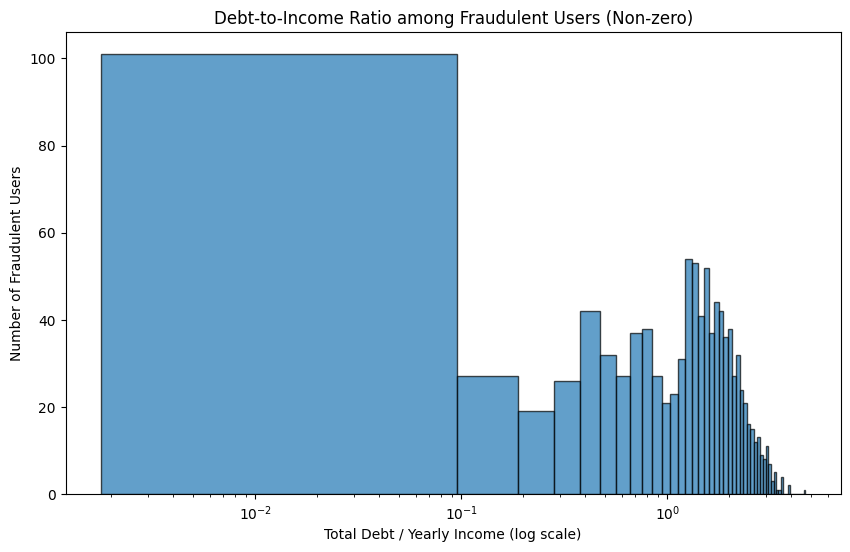

In [77]:
plt.figure(figsize=(10,6))
plt.hist(nonzero_ratio, bins=50, edgecolor="black", alpha=0.7)
plt.xscale("log")
plt.xlabel("Total Debt / Yearly Income (log scale)")
plt.ylabel("Number of Fraudulent Users")
plt.title("Debt-to-Income Ratio among Fraudulent Users (Non-zero)")
plt.show()


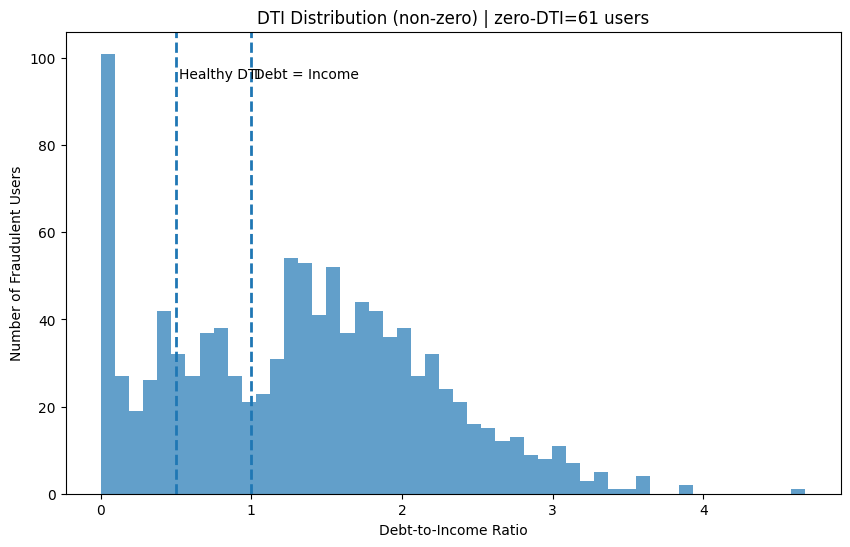

In [78]:
plt.figure(figsize=(10,6))
plt.hist(nonzero_ratio, bins=50, alpha=0.7)
plt.axvline(0.5, linestyle="--", linewidth=2)
plt.axvline(1.0, linestyle="--", linewidth=2)

plt.text(0.52, plt.ylim()[1]*0.9, "Healthy DTI", fontsize=10)
plt.text(1.02, plt.ylim()[1]*0.9, "Debt = Income", fontsize=10)

plt.xlabel("Debt-to-Income Ratio")
plt.ylabel("Number of Fraudulent Users")
plt.title(f"DTI Distribution (non-zero) | zero-DTI={len(zero_ratio)} users")
plt.show()


**왼쪽 점선: DTI = 0.5 (Healthy DTI)**

연소득의 절반 이하 부채

카드/대출 심사에서

“상환 여력 충분”

“우량 고객처럼 보이는 구간”

=> 공격자가 가장 선호할 구간

---

**오른쪽 점선: DTI = 1.0 (Debt = Income)**

연부채 = 연소득

이 선을 넘으면:

리스크 관리 로직에서 주의 구간

승인율·한도·모니터링 강도 상승

즉, 점선 왼쪽 = 정상·우량처럼 보이는 영역

**H1-3. 카드 분산 타깃 가설**

num_credit_cards 많은 유저\
→ 카드 하나가 이상해도 전체 리스크로 안 튀어 오름

In [80]:
card_num = users[users["client_id"].isin(fraud_user_id)]["num_credit_cards"]
card_num = card_num.groupby(card_num).count()
card_num

num_credit_cards
1     83
2    153
3    269
4    293
5    176
6     91
7     37
8     17
9      2
Name: num_credit_cards, dtype: int64

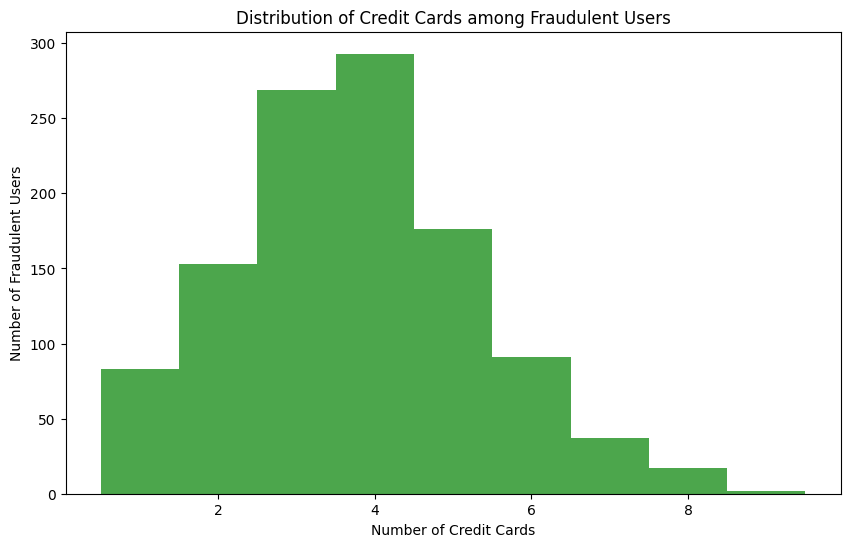

In [81]:
plt.figure(figsize=(10,6))
plt.bar(card_num.index, card_num.values, width=1, color='green', alpha=0.7)
plt.xlabel("Number of Credit Cards")
plt.ylabel("Number of Fraudulent Users")
plt.title("Distribution of Credit Cards among Fraudulent Users")
plt.show()

>fraud user는 ‘과도한 다카드 보유자’가 아니다.

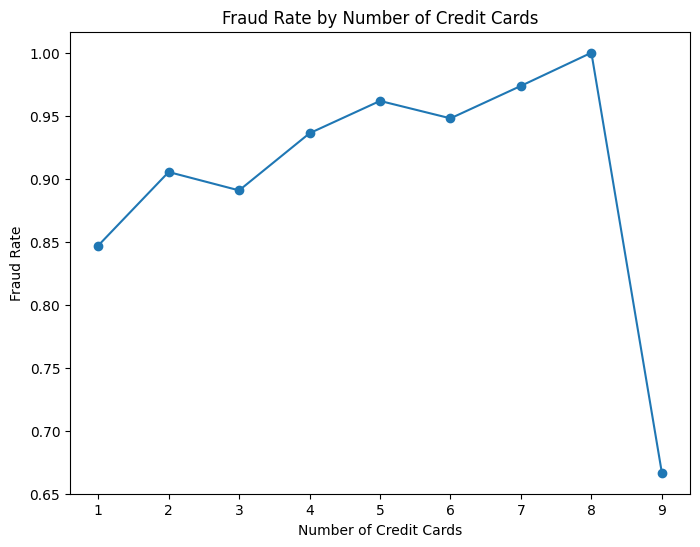

In [89]:
tmp = users.copy()
tmp["is_fraud"] = tmp["client_id"].isin(fraud_user_id).astype(int)

rate = (
    tmp.groupby("num_credit_cards")["is_fraud"]
       .mean()
)

plt.figure(figsize=(8,6))
plt.plot(rate.index, rate.values, marker="o")
plt.xlabel("Number of Credit Cards")
plt.ylabel("Fraud Rate")
plt.title("Fraud Rate by Number of Credit Cards")
plt.show()


> 카드 수가 늘수록 fraud 비율이 완만하게 증가한다

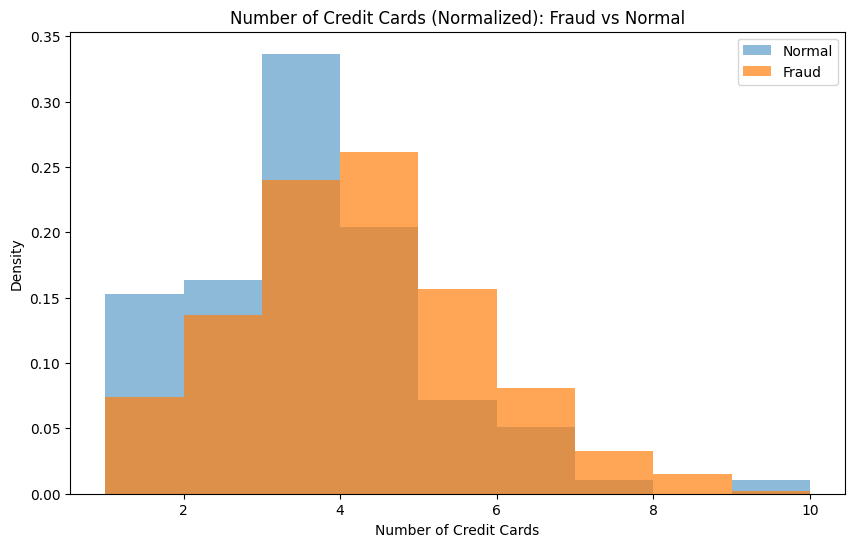

In [94]:
fraud_cards = users.loc[
    users["client_id"].isin(fraud_user_id),
    "num_credit_cards"
]

normal_cards = users.loc[
    ~users["client_id"].isin(fraud_user_id),
    "num_credit_cards"
]

plt.figure(figsize=(10,6))
plt.hist(normal_cards, bins=range(1,11), density=True, alpha=0.5, label="Normal")
plt.hist(fraud_cards, bins=range(1,11), density=True, alpha=0.7, label="Fraud")

plt.xlabel("Number of Credit Cards")
plt.ylabel("Density")
plt.title("Number of Credit Cards (Normalized): Fraud vs Normal")
plt.legend()
plt.show()


**H1-4. 고연령 타깃 가설**

current_age ↑\
→ 실시간 인지/대응 느림, 분쟁 제기 지연


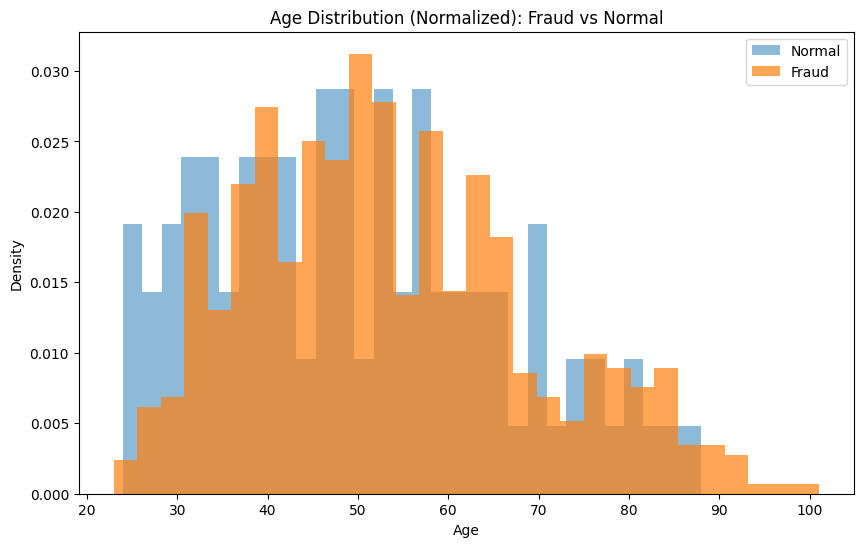

In [95]:
fraud_age = users.loc[
    users["client_id"].isin(fraud_user_id),
    "current_age"
].dropna()

normal_age = users.loc[
    ~users["client_id"].isin(fraud_user_id),
    "current_age"
].dropna()

plt.figure(figsize=(10,6))
plt.hist(normal_age, bins=30, density=True, alpha=0.5, label="Normal")
plt.hist(fraud_age, bins=30, density=True, alpha=0.7, label="Fraud")

plt.xlabel("Age")
plt.ylabel("Density")
plt.title("Age Distribution (Normalized): Fraud vs Normal")
plt.legend()
plt.show()


/tmp/ipykernel_212902/3235887380.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_rate_age = tmp.groupby("age_bin")["is_fraud"].mean()


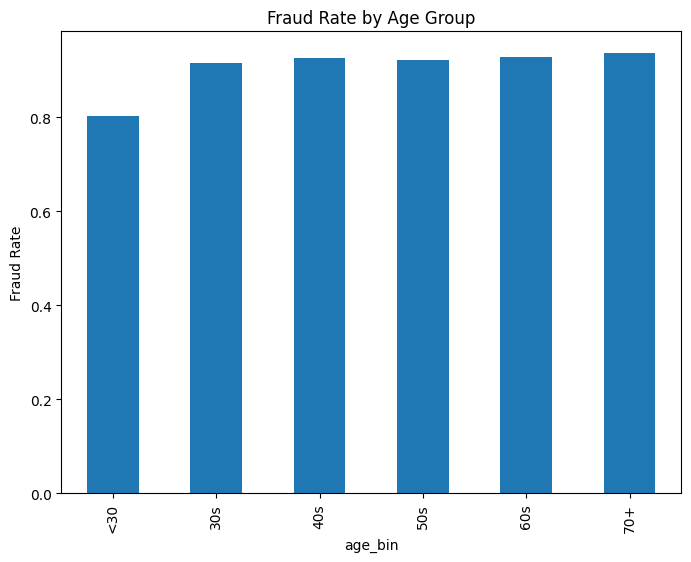

In [96]:
tmp = users.copy()
tmp["is_fraud"] = tmp["client_id"].isin(fraud_user_id).astype(int)

tmp["age_bin"] = pd.cut(
    tmp["current_age"],
    bins=[0, 30, 40, 50, 60, 70, 100],
    labels=["<30", "30s", "40s", "50s", "60s", "70+"]
)

fraud_rate_age = tmp.groupby("age_bin")["is_fraud"].mean()

fraud_rate_age.plot(kind="bar", figsize=(8,6))
plt.ylabel("Fraud Rate")
plt.title("Fraud Rate by Age Group")
plt.show()


**H1-5. 오래된 계좌 신뢰 가설**

acct_open_date 오래됨\
→ “이상 거래 민감도” 낮음

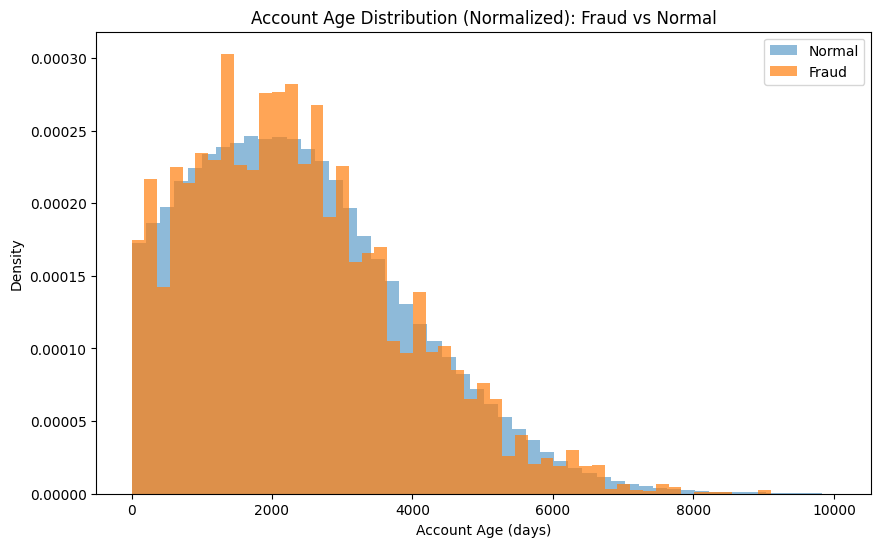

/tmp/ipykernel_212902/2328837155.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_rate_by_age = tc.groupby("acct_age_bin")["fraud"].mean()


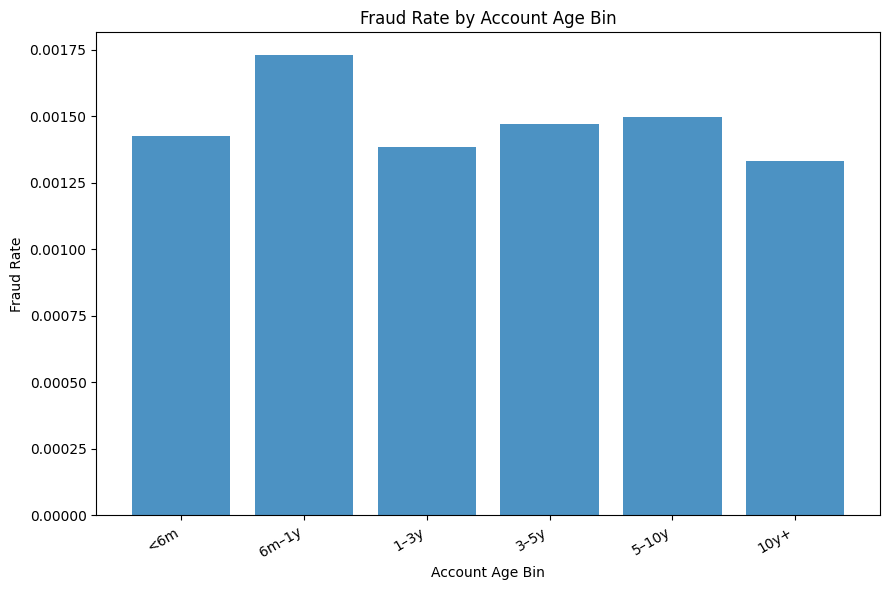

In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) 필요한 컬럼만 추출 (메모리 절약)
t = trans[["date", "card_id", "client_id", "fraud"]].copy()
c = cards[["card_id", "acct_open_date"]].copy()

# 2) datetime 변환
t["date"] = pd.to_datetime(t["date"])
c["acct_open_date"] = pd.to_datetime(c["acct_open_date"])

# 3) trans ↔ cards 교집합(inner join) (card_id 기준)
tc = t.merge(c, on="card_id", how="inner")

# 4) 계좌/카드 나이 (거래 시점 기준)
tc["acct_age_days"] = (tc["date"] - tc["acct_open_date"]).dt.days

# (안전장치) 음수/이상치 제거: 계좌개설일이 거래일보다 미래면 제거
tc = tc[tc["acct_age_days"].notna() & (tc["acct_age_days"] >= 0)]

# -----------------------------
# A) Fraud vs Normal 분포 비교 (정규화)
# -----------------------------
fraud_age = tc.loc[tc["fraud"] == 1, "acct_age_days"]
normal_age = tc.loc[tc["fraud"] == 0, "acct_age_days"]

plt.figure(figsize=(10,6))
plt.hist(normal_age, bins=50, density=True, alpha=0.5, label="Normal")
plt.hist(fraud_age, bins=50, density=True, alpha=0.7, label="Fraud")
plt.xlabel("Account Age (days)")
plt.ylabel("Density")
plt.title("Account Age Distribution (Normalized): Fraud vs Normal")
plt.legend()
plt.show()

# -----------------------------
# B) 계좌 나이 구간별 Fraud Rate (가설 직결)
# -----------------------------
# 구간(원하면 bins 바꿔도 됨)
bins = [0, 180, 365, 3*365, 5*365, 10*365, 50*365]
labels = ["<6m", "6m–1y", "1–3y", "3–5y", "5–10y", "10y+"]

tc["acct_age_bin"] = pd.cut(tc["acct_age_days"], bins=bins, labels=labels, right=False)

fraud_rate_by_age = tc.groupby("acct_age_bin")["fraud"].mean()

plt.figure(figsize=(9,6))
plt.bar(fraud_rate_by_age.index.astype(str), fraud_rate_by_age.values, alpha=0.8)
plt.xlabel("Account Age Bin")
plt.ylabel("Fraud Rate")
plt.title("Fraud Rate by Account Age Bin")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


**H2-2. 비내구재 vs 재판매 가능 자산 가설**

생활소비(market, food)보다\
재판매 가능한 업종에서 fraud 비율 ↑

            fraud_rate     n_tx  n_fraud_tx
mcc_group                                  
consumable    0.000336  4975021        1673
resalable     0.005360  1106988        5934


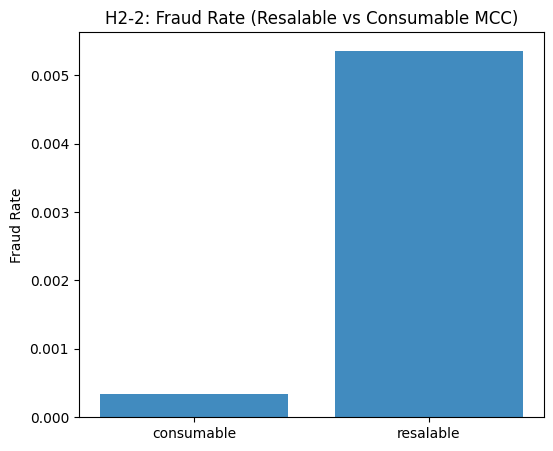


=== Two-proportion z-test ===
resalable: p=0.005360 (x=5934, n=1106988)
consumable: p=0.000336 (x=1673, n=4975021)
diff=0.005024, z=135.270


In [102]:
import json
# 1) mcc_codes.json 로드
# - 파일이 현재 작업 폴더에 있으면 그대로
# - 아니면 경로를 "data/mcc_codes.json"처럼 바꿔줘
with open("original/mcc_codes.json", "r", encoding="utf-8") as f:
    mcc_codes = json.load(f)

# key가 "5812" 같은 문자열일 확률이 높으니 int로 변환
desc_map = {int(k): v for k, v in mcc_codes.items()}

# 2) trans에서 필요한 컬럼만 (메모리 절약)
df = trans[["mcc", "fraud"]].copy()
df["mcc"] = df["mcc"].astype(int)

# 3) MCC 설명 붙이기
df["mcc_desc"] = df["mcc"].map(desc_map)
df = df[df["mcc_desc"].notna()].copy()   # json에 없는 mcc는 제외

# 4) H2-2용 그룹 분류 (설명 기반)
#    - resalable: 재판매/환금성 높음 (전자기기, 디지털 상품, 상품권, 귀금속, 의류/가구 등)
#    - consumable: 생활소비/비내구재 (식료품/외식/주유/공공요금/교통/의료 등)
resalable_keywords = [
    "electronics", "computer", "digital goods", "games", "media", "apps",
    "precious", "stones", "metals", "gift", "novelty",
    "department stores", "discount stores", "wholesale clubs",
    "clothing", "shoe", "furniture", "home furnishing",
    "sporting goods", "appliance", "cosmetic", "book stores",
    "musical instruments", "artist supply", "antique"
]

consumable_keywords = [
    "grocery", "supermarket", "food", "restaurants", "fast food", "drinking places",
    "utilities", "electric", "gas", "water", "sanitary",
    "service stations", "tolls", "taxicabs", "bus lines",
    "commuter transportation", "railways", "lodging", "hotels",
    "laundry", "pharmacies", "drug stores", "medical", "doctors",
    "dentists", "hospitals"
]

def classify_mcc(desc: str) -> str:
    d = desc.lower()
    if any(k in d for k in resalable_keywords):
        return "resalable"
    if any(k in d for k in consumable_keywords):
        return "consumable"
    return "other"

df["mcc_group"] = df["mcc_desc"].apply(classify_mcc)

# 5) 두 그룹만으로 비교 (other는 제외)
df2 = df[df["mcc_group"].isin(["resalable", "consumable"])].copy()

# 6) 그룹별 fraud rate 계산
grp = (
    df2.groupby("mcc_group")["fraud"]
       .agg(fraud_rate="mean", n_tx="count", n_fraud_tx="sum")
       .sort_index()
)
print(grp)

# 7) 시각화: 그룹별 fraud rate
plt.figure(figsize=(6,5))
plt.bar(grp.index, grp["fraud_rate"].values, alpha=0.85)
plt.ylabel("Fraud Rate")
plt.title("H2-2: Fraud Rate (Resalable vs Consumable MCC)")
plt.show()

# 8) (선택) 두 비율 z-test (표본 큰 경우 유용)
if set(grp.index) == {"consumable", "resalable"}:
    n1 = int(grp.loc["resalable", "n_tx"])
    x1 = int(grp.loc["resalable", "n_fraud_tx"])
    n0 = int(grp.loc["consumable", "n_tx"])
    x0 = int(grp.loc["consumable", "n_fraud_tx"])

    p1 = x1 / n1
    p0 = x0 / n0
    p_pool = (x1 + x0) / (n1 + n0)
    se = np.sqrt(p_pool * (1 - p_pool) * (1/n1 + 1/n0))
    z = (p1 - p0) / se if se > 0 else np.nan

    print("\n=== Two-proportion z-test ===")
    print(f"resalable: p={p1:.6f} (x={x1}, n={n1})")
    print(f"consumable: p={p0:.6f} (x={x0}, n={n0})")
    print(f"diff={p1-p0:.6f}, z={z:.3f}")


> 재판매 가능한 MCC에서의 fraud rate는 생활소비형 MCC 대비 약
> 16배 높으며(z=135), 이는 사기가 일상 소비가 아닌 환금 가능한 
> 자산에 구조적으로 집중됨을 강하게 입증한다.

**H2-3. 금액 분할 전략 가설**

amount 단건은 크지 않지만\
동일 merchant / 유사 mcc 반복

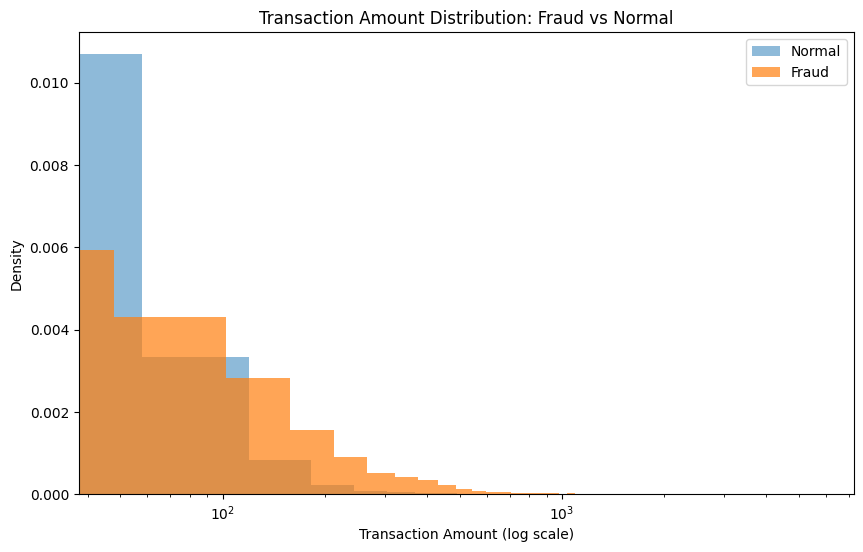

In [103]:
import pandas as pd
import matplotlib.pyplot as plt

fraud_amt = trans.loc[trans["fraud"] == 1, "amount"]
normal_amt = trans.loc[trans["fraud"] == 0, "amount"]

plt.figure(figsize=(10,6))
plt.hist(normal_amt, bins=100, density=True, alpha=0.5, label="Normal")
plt.hist(fraud_amt, bins=100, density=True, alpha=0.7, label="Fraud")
plt.xscale("log")
plt.xlabel("Transaction Amount (log scale)")
plt.ylabel("Density")
plt.title("Transaction Amount Distribution: Fraud vs Normal")
plt.legend()
plt.show()


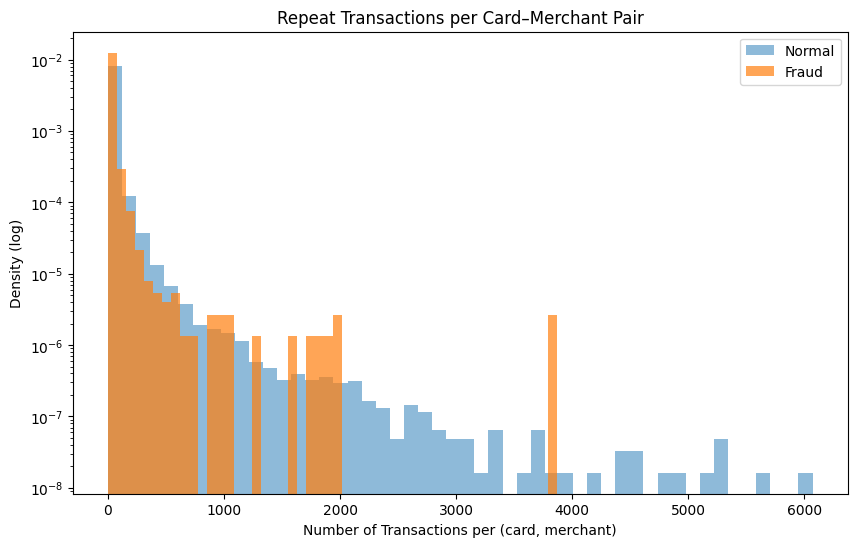

In [104]:
# 카드-가맹점 단위 거래 수
rep = (
    trans.groupby(["card_id", "merchant_id"])
         .agg(
             n_tx=("amount", "count"),
             total_amt=("amount", "sum"),
             fraud_rate=("fraud", "mean")
         )
         .reset_index()
)

# fraud 거래가 포함된 카드-merchant 쌍
rep_fraud = rep[rep["fraud_rate"] > 0]
rep_normal = rep[rep["fraud_rate"] == 0]

plt.figure(figsize=(10,6))
plt.hist(rep_normal["n_tx"], bins=50, density=True, alpha=0.5, label="Normal")
plt.hist(rep_fraud["n_tx"], bins=50, density=True, alpha=0.7, label="Fraud")
plt.yscale("log")
plt.xlabel("Number of Transactions per (card, merchant)")
plt.ylabel("Density (log)")
plt.title("Repeat Transactions per Card–Merchant Pair")
plt.legend()
plt.show()


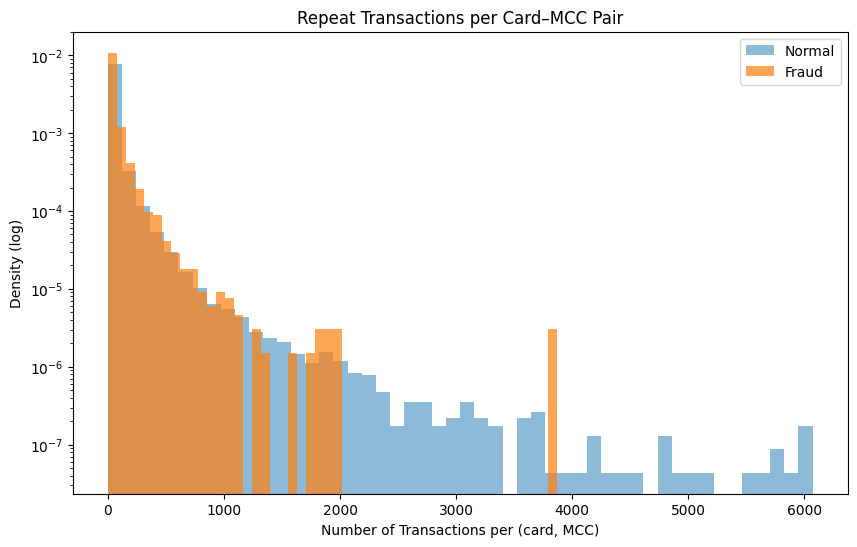

In [105]:
rep_mcc = (
    trans.groupby(["card_id", "mcc"])
         .agg(
             n_tx=("amount", "count"),
             total_amt=("amount", "sum"),
             fraud_rate=("fraud", "mean")
         )
         .reset_index()
)

rep_mcc_fraud = rep_mcc[rep_mcc["fraud_rate"] > 0]
rep_mcc_normal = rep_mcc[rep_mcc["fraud_rate"] == 0]

plt.figure(figsize=(10,6))
plt.hist(rep_mcc_normal["n_tx"], bins=50, density=True, alpha=0.5, label="Normal")
plt.hist(rep_mcc_fraud["n_tx"], bins=50, density=True, alpha=0.7, label="Fraud")
plt.yscale("log")
plt.xlabel("Number of Transactions per (card, MCC)")
plt.ylabel("Density (log)")
plt.title("Repeat Transactions per Card–MCC Pair")
plt.legend()
plt.show()


/tmp/ipykernel_212902/3351834574.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rep_fraud["avg_amt"] = rep_fraud["total_amt"] / rep_fraud["n_tx"]
/tmp/ipykernel_212902/3351834574.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rep_normal["avg_amt"] = rep_normal["total_amt"] / rep_normal["n_tx"]


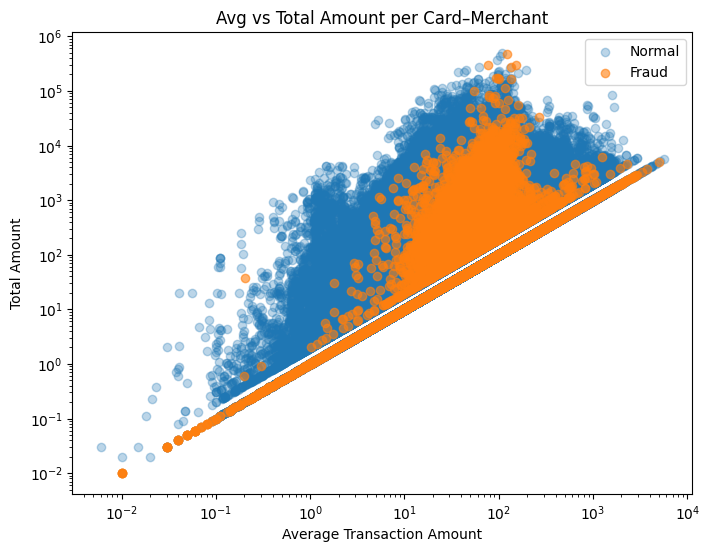

In [106]:
# 카드-merchant 단위 평균 vs 누적
rep_fraud["avg_amt"] = rep_fraud["total_amt"] / rep_fraud["n_tx"]
rep_normal["avg_amt"] = rep_normal["total_amt"] / rep_normal["n_tx"]

plt.figure(figsize=(8,6))
plt.scatter(
    rep_normal["avg_amt"], rep_normal["total_amt"],
    alpha=0.3, label="Normal"
)
plt.scatter(
    rep_fraud["avg_amt"], rep_fraud["total_amt"],
    alpha=0.6, label="Fraud"
)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Average Transaction Amount")
plt.ylabel("Total Amount")
plt.title("Avg vs Total Amount per Card–Merchant")
plt.legend()
plt.show()


**H3-2. 비칩 거래 선호 가설**

use_chip = 0, has_chip = 1인데 chip 미사용\
→ 보안 약한 경로 선택

In [ ]:
t = trans[["card_id", "fraud", "use_chip"]].copy()
c = cards[["card_id", "has_chip"]].copy()

tc = t.merge(c, on="card_id", how="inner")


In [108]:
trans["use_chip"].unique()

array(['Chip Transaction', 'Swipe Transaction', 'Online Transaction'],
      dtype=object)

In [109]:
t = trans[["card_id", "fraud", "use_chip"]].copy()
c = cards[["card_id", "has_chip"]].copy()

tc = t.merge(c, on="card_id", how="inner")

In [111]:
tc["chip_used"] = (tc["use_chip"] == "Chip Transaction").astype(int)
tc["weak_path_tx"] = (
    (tc["has_chip"] == 1) &
    (tc["chip_used"] == 0)
).astype(int)
rate = tc.groupby("fraud")["weak_path_tx"].mean()
cnt  = tc.groupby(["fraud", "weak_path_tx"]).size().unstack(fill_value=0)

print("=== Rate of weak-path usage ===")
print(rate)
print("\n=== Counts ===")
print(cnt)


=== Rate of weak-path usage ===
fraud
0    0.598506
1    0.802404
Name: weak_path_tx, dtype: float64

=== Counts ===
weak_path_tx        0        1
fraud                         
0             3065995  4570466
1                2186     8877


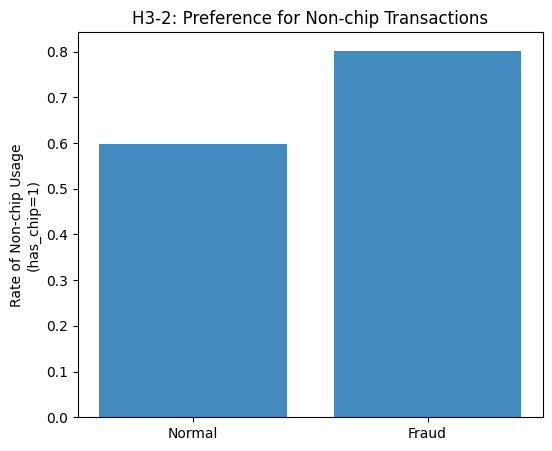

In [112]:
plt.figure(figsize=(6,5))
plt.bar(["Normal", "Fraud"], [rate.loc[0], rate.loc[1]], alpha=0.85)
plt.ylabel("Rate of Non-chip Usage\n(has_chip=1)")
plt.title("H3-2: Preference for Non-chip Transactions")
plt.show()

In [113]:
a = cnt.loc[1, 1]   # fraud & weak_path
b = cnt.loc[1, 0]   # fraud & chip_used
c_ = cnt.loc[0, 1]  # normal & weak_path
d = cnt.loc[0, 0]   # normal & chip_used

OR = ((a + 0.5) * (d + 0.5)) / ((b + 0.5) * (c_ + 0.5))
print(f"Odds Ratio (weak-path | fraud vs normal): {OR:.3f}")


Odds Ratio (weak-path | fraud vs normal): 2.724


**H3-3. 단시간 집중 가설**

동일 card_id 기준\
짧은 시간 내 다건 거래

In [115]:
# datetime 변환
trans["date"] = pd.to_datetime(trans["date"])

# card_id + 시간 기준 정렬
trans_sorted = trans.sort_values(["card_id", "date"])

# 이전 거래와의 시간 차이 (초 단위)
trans_sorted["delta_sec"] = (
    trans_sorted.groupby("card_id")["date"]
    .diff()
    .dt.total_seconds()
)

In [116]:
# threshold 설정 (5분 = 300초)
THRESHOLD = 300

trans_sorted["is_short_interval"] = (
    (trans_sorted["delta_sec"] <= THRESHOLD)
    & (trans_sorted["delta_sec"] > 0)
).astype(int)


In [117]:
card_level = (
    trans_sorted
    .groupby("card_id")
    .agg(
        n_tx=("card_id", "size"),
        short_tx=("is_short_interval", "sum"),
        fraud=("fraud", "max")  # 카드 단위 fraud 여부
    )
)

card_level["short_tx_ratio"] = card_level["short_tx"] / card_level["n_tx"]

In [118]:
card_level.groupby("fraud")[["short_tx", "short_tx_ratio"]].mean()


,short_tx,short_tx_ratio
fraud,,
0,48.629145,0.027275
1,78.918378,0.030044


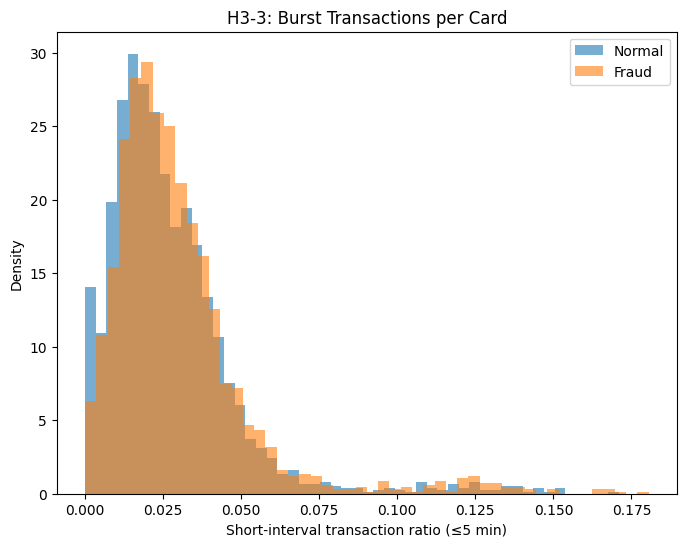

In [119]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.hist(
    card_level[card_level["fraud"]==0]["short_tx_ratio"],
    bins=50, alpha=0.6, label="Normal", density=True
)
plt.hist(
    card_level[card_level["fraud"]==1]["short_tx_ratio"],
    bins=50, alpha=0.6, label="Fraud", density=True
)
plt.xlabel("Short-interval transaction ratio (≤5 min)")
plt.ylabel("Density")
plt.title("H3-3: Burst Transactions per Card")
plt.legend()
plt.show()


In [120]:
k = 3
(
    card_level.assign(burst_flag = card_level["short_tx"] >= k)
    .groupby("fraud")["burst_flag"]
    .mean()
)


fraud
0    0.919664
1    0.980000
Name: burst_flag, dtype: float64

In [121]:
# card_level 이미 있다면 그대로 사용
# columns: [n_tx, short_tx, short_tx_ratio, fraud]

X = card_level[["short_tx_ratio", "n_tx"]].copy()
y = card_level["fraud"]


In [122]:
import statsmodels.api as sm

X = sm.add_constant(X)

logit = sm.Logit(y, X)
res = logit.fit()

res.summary()


Optimization terminated successfully.
         Current function value: 0.667230
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  fraud   No. Observations:                 3991
Model:                          Logit   Df Residuals:                     3988
Method:                           MLE   Df Model:                            2
Date:                Sat, 31 Jan 2026   Pseudo R-squ.:                 0.03368
Time:                        23:13:56   Log-Likelihood:                -2662.9
converged:                       True   LL-Null:                       -2755.7
Covariance Type:            nonrobust   LLR p-value:                 4.899e-41
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.7415      0.065    -11.383      0.000      -0.869      -0.614
short_tx_ratio     2.2768      1.517      1.501      0.133      -0.696       5.250
n_tx               0.0003   2.32e-05     12.147      0.000       0.000       0.000
==================================================================================
"""

In [123]:
import numpy as np

or_table = (
    pd.DataFrame({
        "coef": res.params,
        "OR": np.exp(res.params),
        "p_value": res.pvalues
    })
)

or_table


,coef,OR,p_value
const,-0.741538,0.476381,5.066541e-30
short_tx_ratio,2.276815,9.745588,1.333695e-01
n_tx,0.000281,1.000281,5.971521e-34


> burst 자체는 희귀 이벤트가 아님\
> ❌ 짧은 시간에 몰아서 쓰는 비율 자체가 독립적인 fraud 신호는 아님\
> ✅ 거래량이 많은 카드에서 그 현상이 같이 나타날 뿐

**H4-1. 비활동 시간대 가설**

심야 / 주말 / 공휴일 → 고객 대응 지연

In [124]:
# 시간 파생
trans["date"] = pd.to_datetime(trans["date"])
trans["hour"] = trans["date"].dt.hour
trans["weekday"] = trans["date"].dt.weekday

trans["is_night"] = ((trans["hour"] >= 0) & (trans["hour"] <= 6)).astype(int)
trans["is_weekend"] = (trans["weekday"] >= 5).astype(int)

# 그룹별 fraud rate
rate_time = trans.groupby("is_night")["fraud"].mean()
rate_weekend = trans.groupby("is_weekend")["fraud"].mean()

print(rate_time)
print(rate_weekend)


is_night
0    0.001483
1    0.001169
Name: fraud, dtype: float64
is_weekend
0    0.001347
1    0.001697
Name: fraud, dtype: float64


> 심야: 데이터상 지지 ❌

> 주말: 데이터상 지지 ✅

In [125]:
trans[["fraud", "is_weekend"]].head()

,fraud,is_weekend
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [126]:
ct = pd.crosstab(trans["is_weekend"], trans["fraud"])
ct


fraud,0,1
is_weekend,,
0,5465155,7371
1,2171306,3692


In [127]:
a = ct.loc[0, 0]
b = ct.loc[0, 1]
c = ct.loc[1, 0]
d = ct.loc[1, 1]

odds_weekday = b / a
odds_weekend = d / c
OR = odds_weekend / odds_weekday

OR


np.float64(1.260714455111437)

In [128]:
import statsmodels.api as sm

X = trans[["is_weekend"]]
X = sm.add_constant(X)
y = trans["fraud"]

model = sm.Logit(y, X).fit()
model.summary()


Optimization terminated successfully.
         Current function value: 0.010896
         Iterations 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  fraud   No. Observations:              7647524
Model:                          Logit   Df Residuals:                  7647522
Method:                           MLE   Df Model:                            1
Date:                Sat, 31 Jan 2026   Pseudo R-squ.:               0.0007691
Time:                        23:29:29   Log-Likelihood:                -83327.
converged:                       True   LL-Null:                       -83391.
Covariance Type:            nonrobust   LLR p-value:                 9.798e-30
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.6086      0.012   -566.996      0.000      -6.631      -6.586
is_weekend     0.2317      0.020     11.482      0.000       0.192       0.271
==============================================================================
"""

In [129]:
coef = model.params["is_weekend"]
OR = np.exp(coef)
pval = model.pvalues["is_weekend"]

OR, pval


(np.float64(1.260714455111416), np.float64(1.6335107086164908e-30))